# <b>Project 2 - HDB Resale Price Prediction and Analysis</b>
---

# Table of Contents
1. Introduction and Project Objectives
2. Preliminary Data Exploration and Hypothesis Formation
3. Outline of Data Processing and Analysis
    - 3.1. Data Cleaning
    - 3.2. Feature Engineering
    - 3.3. Feature Selection and Column Dropping
    - 3.4. Hyperparameter Tuning and Model-Fitting
4. Creation of Pipelines
5. Business Insights 
6. Suggestions for Further Research

### Appendix
- A. Comparing coefficients of the three models
- B: Analysis of Variance Inflation Factor
- C: Using `statsmodels.api` to check statistical significance
- D: Visualizations for presentation of data

# 1. Introduction and Project Objectives

Determining the true sale price of an HDB resale flat in Singapore can be a complex task, influenced by a myriad of factors, including but not limited to location, amenities, surrounding and future town developments, number of rooms and even government policies.

The data that we have on the HDB flats are sourced from [Kaggle](https://www.kaggle.com/competitions/dsi-sg-project-2-regression-challenge-hdb-price/data), and comprise the following:
- HDB resale prices over ~ 9 years (2012-03 to 2021-04), split into:
    - Training dataset: ~ 150,000 observations 
    - Testing dataset: ~ 16,500 observations
- Data on a wide range of housing attributes comprising over 70 data columns, and covering the following broad attribute categories:
    - Apartments' individual physical characteristics
    - Apartments' individual remaining lease period
    - Apartments' housing block characteristics
    - Surrounding transport infrastructure
    - Surrounding amenities
    - Surrounding schools


---

# 2. Preliminary Data Exploration and Hypothesis Formation

- The process of (i) formulating hypotheses about factors associated with HDB resale prices, and (ii) engineering features to test these hypotheses were guided by:

    - An interview with a practicing property agent 
    - A review of the literature: covering research papers, op-eds, and newspaper articles

- This section is structured by hypothesis, and proceeds in the following sequence at the hypothesis-level:

    - Hypothesis -> EDA - Data Cleaning - Feature Engineering (*where relevant*)

- Categories of features hypothesised to be associated with HDB resale prices are:

    - Apartment's :: Physical Characteristics
    - Apartment's :: Remaining Lease Period (RLP)
    - Accessibility to Transport Infrastructure
    - Proximity to the Central Business District (CBD)
    - Accessibility to Amenities
    - Accessibility to Schools

- Dataset worked with: Training Data

<b>Addendum</b>: In the spirit of wanting our data cleaning, feature engineering, and pre-processing to be replicable and black-boxed for later use, we will take note of the data cleaning and processing steps at each stage we perform it on an initial exploratory dataset.

### Library Imports

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


from collections import deque

# Custom python script containing all mrt info and
# implementation of Dijkstra's algorithm
# This is completely self-contained
from mrt_tools import mrt_scores_per_station

The dictionary `mrt_scores_per_station` below is a lookup table pre-calculated to save runtime. Further details in section 3.2 Feature Engineering, under MRT features.

In [6]:
mrt_scores_per_station

{'Esplanade': 0,
 'Lentor': 11,
 'Telok Blangah': 0,
 'Tanjong Pagar': 0,
 'Maxwell': 0,
 'Chinatown': 1,
 'Caldecott': 7,
 'Woodlands South': 13,
 'Marsiling': 15,
 'Telok Ayer': 0,
 'Hougang': 10,
 'Lakeside': 10,
 'Potong Pasir': 6,
 'Shenton Way': 0,
 'Little India': 3,
 'Kembangan': 7,
 'Serangoon': 8,
 'Sixth Avenue': 8,
 'Upper Changi': 13,
 'Bayfront': 0,
 'Punggol': 13,
 'Novena': 5,
 'Rochor': 2,
 'Keat Hong': 15,
 'Harbourfront': 0,
 'Marina South Pier': 1,
 'Buangkok': 11,
 'City Hall': 0,
 'Marymount': 9,
 'Tai Seng': 7,
 'Holland Village': 7,
 'Yew Tee': 13,
 'Eunos': 6,
 'Kallang': 3,
 'Botanic Gardens': 6,
 'Bukit Panjang': 13,
 'Geylang Bahru': 6,
 'Gardens By The Bay': 1,
 'Khatib': 11,
 'Farrer Road': 8,
 'Mattar': 7,
 'Woodleigh': 7,
 'Promenade': 0,
 'Lorong Chuan': 10,
 'Tuas Crescent': 15,
 'Tampines West': 12,
 'King Albert Park': 9,
 'Bencoolen': 3,
 'Tuas Link': 17,
 'Canberra': 13,
 'Outram Park': 0,
 'Kent Ridge': 4,
 'Tan Kah Kee': 7,
 'Bras Basah': 1,
 'Ch

We import a copy of the training data for the sole purpose of exploratory data analysis. A fresh copy of the training data will be reloaded when we perform the actual model-fitting and predictions. This is to ensure that 
1. The data is sanitized against any unintended changes from exploratory analysis, and
2. Our cleaning and processing workflow actually functions as intended.

In [7]:
exploratory_train_df = pd.read_csv('data/train.csv')

C:\Users\Aspire\AppData\Local\Temp\ipykernel_6148\2015125573.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  exploratory_train_df = pd.read_csv('data/train.csv')


In [8]:
# checking shape and datatypes
print(exploratory_train_df.shape)
exploratory_train_df.info()

(150634, 77)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 77 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         150634 non-null  int64  
 1   Tranc_YearMonth            150634 non-null  object 
 2   town                       150634 non-null  object 
 3   flat_type                  150634 non-null  object 
 4   block                      150634 non-null  object 
 5   street_name                150634 non-null  object 
 6   storey_range               150634 non-null  object 
 7   floor_area_sqm             150634 non-null  float64
 8   flat_model                 150634 non-null  object 
 9   lease_commence_date        150634 non-null  int64  
 10  resale_price               150634 non-null  float64
 11  Tranc_Year                 150634 non-null  int64  
 12  Tranc_Month                150634 non-null  int64  
 13  mid_storey      

Column names are first renamed to be lowercase for standardisation.

In [9]:
exploratory_train_df.rename(str.lower, axis='columns', inplace=True)
exploratory_train_df.columns

Index(['id', 'tranc_yearmonth', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'resale_price', 'tranc_year', 'tranc_month', 'mid_storey', 'lower',
       'upper', 'mid', 'full_flat_type', 'address', 'floor_area_sqft',
       'hdb_age', 'max_floor_lvl', 'year_completed', 'residential',
       'commercial', 'market_hawker', 'multistorey_carpark',
       'precinct_pavilion', 'total_dwelling_units', '1room_sold', '2room_sold',
       '3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
       'other_room_rental', 'postal', 'latitude', 'longitude', 'planning_area',
       'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km',
       'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m',
       'hawker_within_1km', 'hawker_within_2km', 'hawker_food_stalls',
       'hawker_market_stalls', 'mr

In [10]:
print(exploratory_train_df['residential'].unique())
print(exploratory_train_df['commercial'].unique())
print(exploratory_train_df['market_hawker'].unique())
print(exploratory_train_df['multistorey_carpark'].unique())
print(exploratory_train_df['precinct_pavilion'].unique())

['Y']
['N' 'Y']
['N' 'Y']
['N' 'Y']
['N' 'Y']


In [11]:
# Observing unique values in 'flat_type' column
np.sort(exploratory_train_df['flat_type'].unique())

array(['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE',
       'MULTI-GENERATION'], dtype=object)

In [12]:
# Observing unique values in 'flat_model' column
np.sort(exploratory_train_df['flat_model'].unique())

array(['2-room', 'Adjoined flat', 'Apartment', 'DBSS', 'Improved',
       'Improved-Maisonette', 'Maisonette', 'Model A',
       'Model A-Maisonette', 'Model A2', 'Multi Generation',
       'New Generation', 'Premium Apartment', 'Premium Apartment Loft',
       'Premium Maisonette', 'Simplified', 'Standard', 'Terrace',
       'Type S1', 'Type S2'], dtype=object)

In [13]:
# Observing unique values in 'pri_sch_affiliation' and 'affiliation' columns
print(exploratory_train_df['pri_sch_affiliation'].unique())
print(exploratory_train_df['affiliation'].unique())

[1 0]
[0 1]


#### Initial observations from the training dataset:
- Columns #1 to #5, #8, #17, #18, #44, #56, #62, #66 & #72 are understandably of the string data type, based on the column names printed above.

- Column #1 `tranc_yearmonth` could be converted to datetime format, however to note that this variable will thus be unusable for linear regression. The year and months could instead be dummied into categorical columns for the purpose of linear regression.

- Columns #13 to #16 represent the range of stories as described by column #6 `storey_range`.

    - As info for the storey range is captured in columns #13 to #16, `storey_range` column is redundant.
    - We can use column #16 `mid` (the middle value of the storey range, in int format) as the variable for the unit storey.

- Columns #23 to #27 are Y/N binary (whether or not a specific facility is located near the unit) and can be converted to int instead if necessary for regression.

- Column #41 `postal` should be int, to be cleaned if this feature is used for regression.

- Column #46 to #48 and #50 to #52 have multiple null entries which should be replaced with int 0.

- Column #45 `mall_nearest_distance` has null entries that should not be replaced with 0. A value of 0 in this column would imply that the distance from the unit to the closest mall is 0 meters, when in fact a null entry indicates that there are no malls near the unit.

    - Initial plan was to drop the rows with null values in column #45 (total of 1549 rows out of 150634 rows. will be dropped this way).
    - Instead of the prior plan, an existing online dataset of Singapore malls with their respective coordinates shall be used to engineer a new column for the distance to the nearest mall.

- Column #68 and #74 (corresponding to school affiliation) are 0/1 binary.

#### Initial considerations for regression model
- `tranc_yearmonth` should be converted to an integer format for linear regression

- Locational data can be engineered fromm the latitude and longitude columns.

- `tranc_year` and `lease_commence_date` can be engineered into a column for the remaining lease at the point of transaction.

- A list for prestigious pri and sec schools can be defined to create a column for each. Potentially use the affiliation columns to engineer this.

- `mid` shall be used to represent the unit floor, other columns pertaining to unit floor shall be dropped.

- `flat_model` and `flat_type` to each be one hot encoded

<b> Feature Category - Apartment's :: Physical Characteristics & Summary of EDA Findings </b>

- A-H1: Apartment's Floor Area is Positively Correlated with Resale Price

- A-H2: Apartment's Floor Level is Positively Correlated with Resale Price

- A-H3: Apartment's Structural/Interior Features are Positively Correlated with Resale Price


---
<br>
<b> A-H1: Apartment's Floor Area is Positively Related with Resale Price </b>

<br> <b>Background </b>

While an apartment's floor area is expected to be positively related with resale price, we firstly wish to establish if:
- `flat_type` would be an suitable proxy for `floor_area`

In addition, we wish to examine: 
- If `floor_area` is positively associated with resale price, and if this relationship might be non-linear

Text(0, 0.5, 'Flat Type')

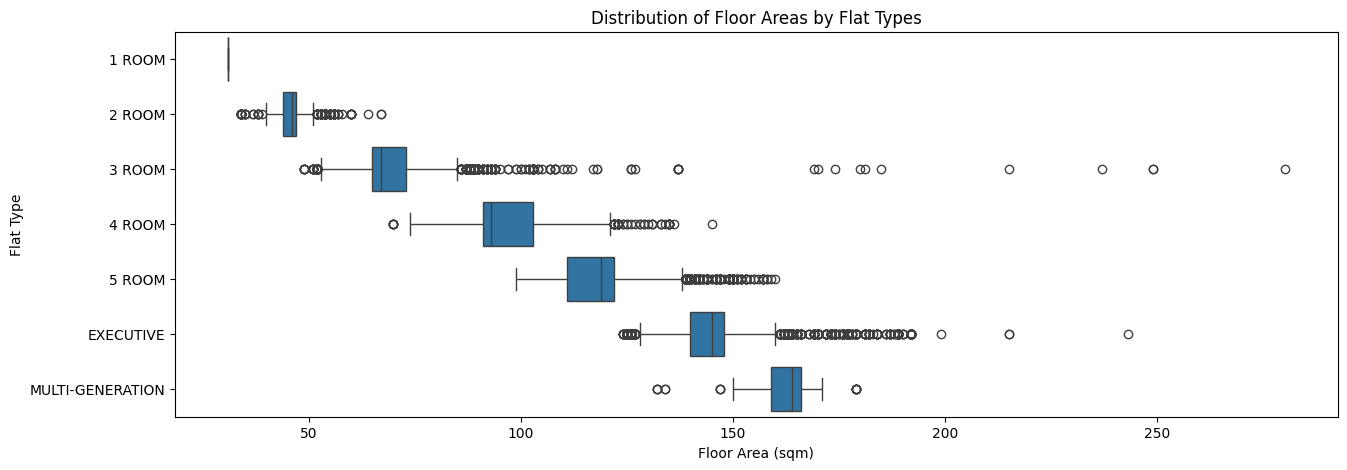

In [14]:
# Display: Boxplot of Floor Area by Flat Type

plt.figure(figsize=(15,5))
sns.boxplot(data=exploratory_train_df, 
            x="floor_area_sqm", 
            y="flat_type", 
            order=["1 ROOM", "2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", "MULTI-GENERATION"])
plt.title("Distribution of Floor Areas by Flat Types")

plt.xlabel('Floor Area (sqm)')
plt.ylabel('Flat Type')

<b> EDA </b>

1. Examine if `flat_type` (e.g., 1 Room, 2 Room) is an appropriate measure of floor area

    * Finding : *Not Appropriate*
    * "Distribution of Floor Area by Flat Type" box plots reveal significant floor area overlaps between a wide range of adjacent `flat_type`s (e.g., "3-4 ROOM", "4-5 ROOM" ...)

2. Examining the relationship between `floor_area` and `resale_price`</b>

    - Correlation analysis & scatterplot examination

Correlation:
                 floor_area_sqm  resale_price
floor_area_sqm         1.00000       0.65412
resale_price           0.65412       1.00000


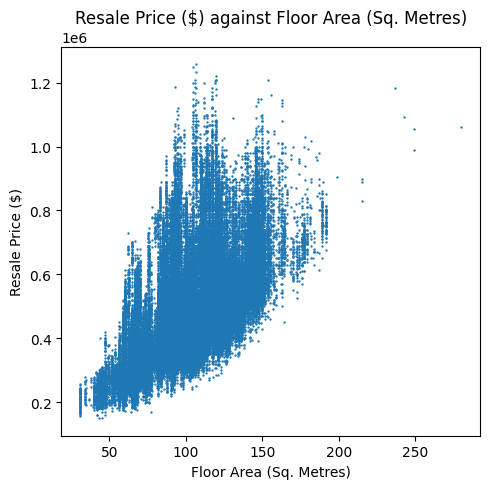

In [15]:
# Display: Relationship between Floor Area & Resale Price

plt.figure(figsize=(5,5))
plt.scatter(exploratory_train_df["floor_area_sqm"], exploratory_train_df["resale_price"], s=0.5)
plt.title("Resale Price ($) against Floor Area (Sq. Metres)")
plt.ylabel("Resale Price ($)")
plt.xlabel("Floor Area (Sq. Metres)")
plt.tight_layout()

print("Correlation:\n", exploratory_train_df[["floor_area_sqm","resale_price"]].corr())

We note the following from the above scatter plot:
- There is a positive correlation between floor area and resale price (0.654) 
- There is a possible non-linear (increasing convex) relationship between the two variables

Thus, it may be a good idea to engineer a squared feature for `floor_area`.

<b> Data Cleaning : Floor Area (Square Meters) </b>



Examine "Floor Areas" by "Flat Type-Model" to Assess If there Might be Outliers
- `flat_type_model` examined as we expect greater convergence in floor areas within these more granular HDB apartment type categories (e.g., 4 Room Model A, 4 Room Model A2)
- Finding (1) : *there clearly are floor area "outliers" that fall outside the "1.5 x Upper (Lower) Quartile" range within each "Flat Type-Model" category*
- Finding (2) : *there is significant clustering of these "outliers" (e.g., 3 Room New Generation, 4 Room New Generation)*  
- Assessment (1) : considering clustering of "outliers", these "outliers" may either reflect `flat_type_model` misclassification instead of measurement error
- Assessment (2) : these "outliers" may not necessarily reflect measurement error, as their clustering may reflect flats sizes that were available at a particular point in time (e.g., 1980s)
- **Conclusion** : leave `floor_area` data as-is, as exceptional floor areas may explain exceptional resale prices

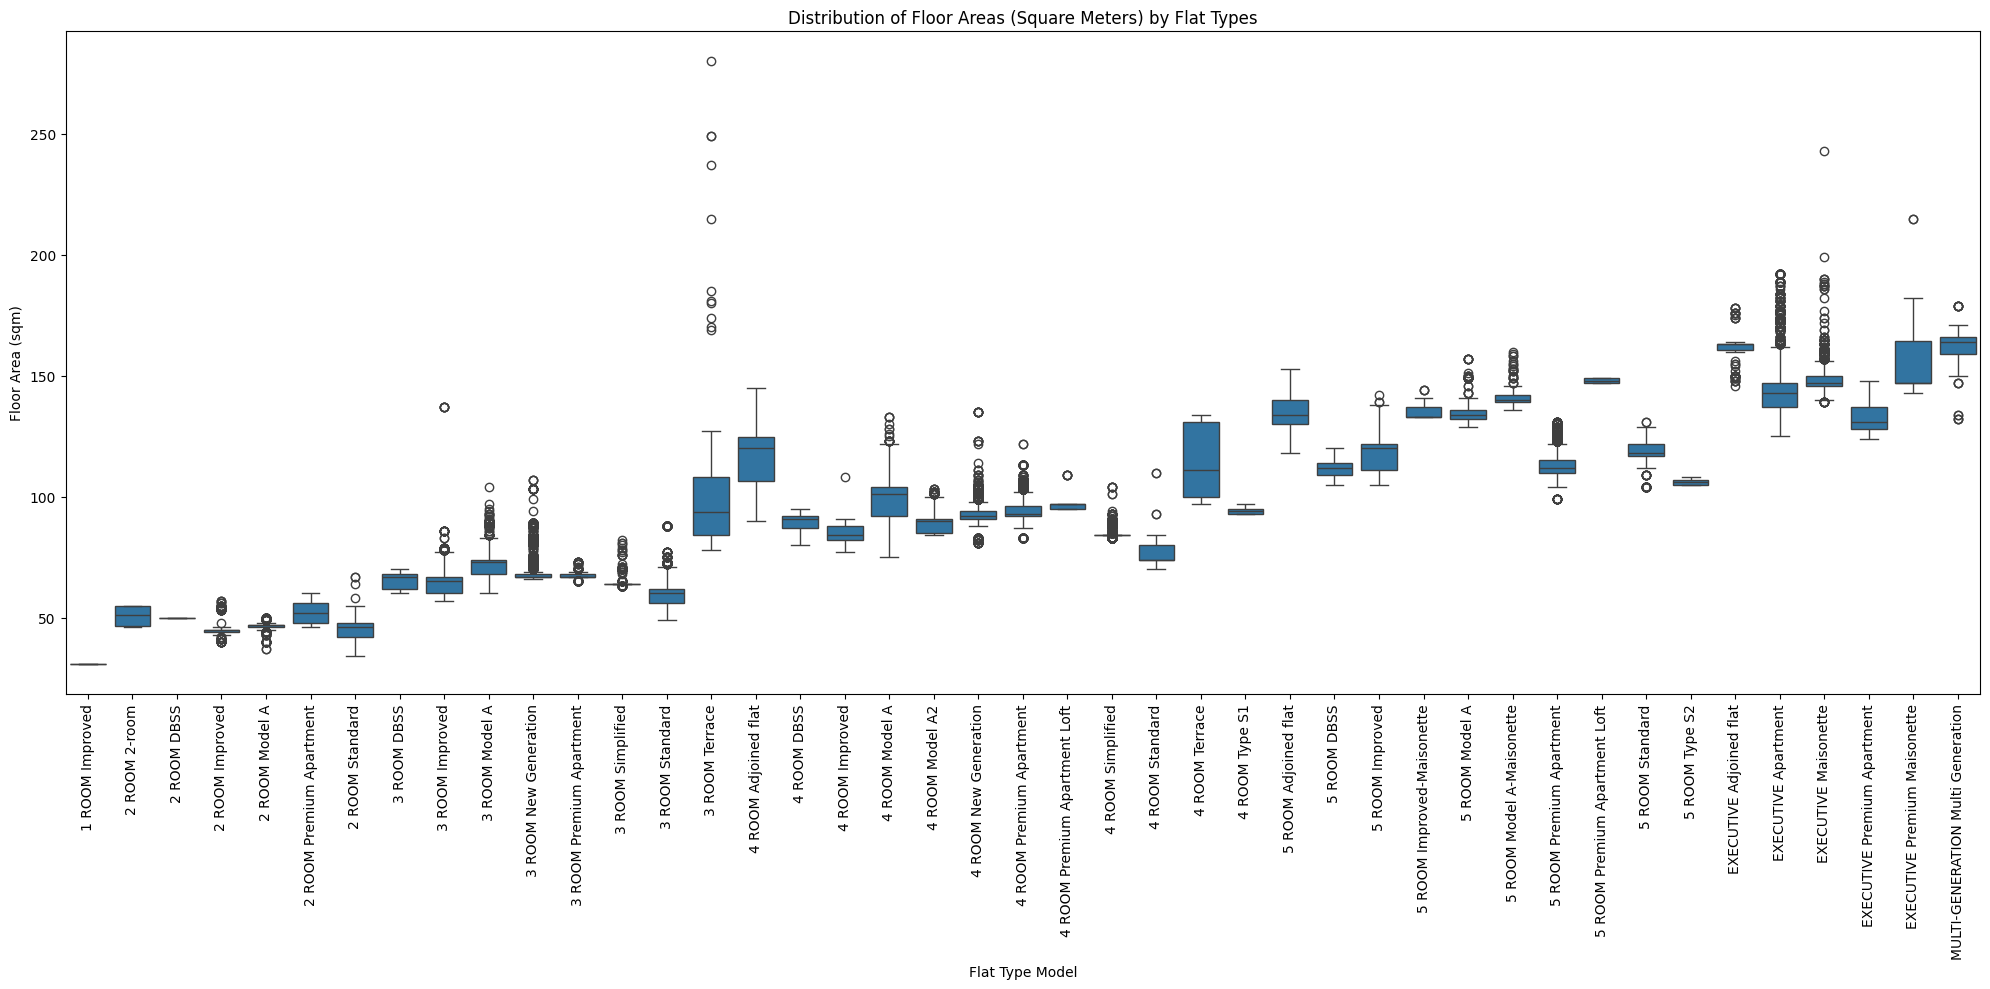

In [16]:
# Add: "Flat Type" + "Flat Model" Variable to Obtain Granular List of Flat Types
exploratory_train_df["flat_type_model"] = exploratory_train_df["flat_type"] + " " + exploratory_train_df["flat_model"]
flat_type_model_list = [type for type in exploratory_train_df["flat_type_model"].unique()]
flat_type_model_list.sort()

# Display: Distribution of Floor Areas by Flat Types
plt.figure(figsize=(20,10))
sns.boxplot(data=exploratory_train_df, y="floor_area_sqm", x="flat_type_model", order=flat_type_model_list)
plt.title("Distribution of Floor Areas (Square Meters) by Flat Types")
plt.xlabel('Flat Type Model')
plt.ylabel('Floor Area (sqm)')
plt.xticks(rotation=90)
plt.tight_layout()

---

<b>A-H2: Apartment's Floor Level is Positively Correlated with Resale Price</b>

<b>  EDA  </b>

1. Examine columns related to an apartment's "floor level" to select an appropriate column to use

    - As we do not have data on the exact "floor level" of an apartment, we'll take `mid` (i.e., middle of the `storey-range`) as a proxy for each apartment's floor level.
    - We note that `mid-storey` and `mid` are exactly the same column, so we choose to drop the redundant `mid-storey`.

2. Examine relationship between "floor level" and `resale_price`

    - Finding: positive correlation (0.353), with wide variation in prices by floor level - suggesting presence of other factors influencing resale prices

Correlation:
                    mid  resale_price
mid           1.000000      0.353213
resale_price  0.353213      1.000000


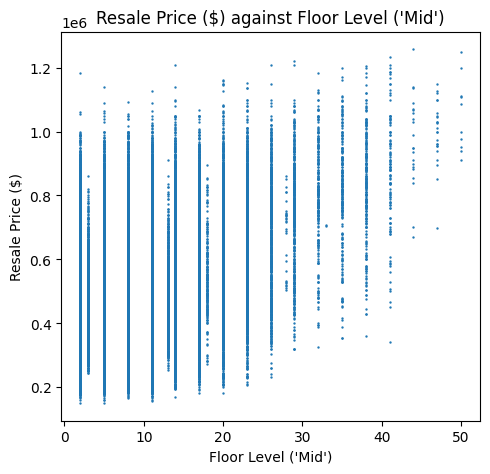

In [17]:
# Display: Relationship between Floor Level & Resale Price

plt.figure(figsize=(5,5))
plt.scatter(exploratory_train_df["mid"], exploratory_train_df["resale_price"], s=0.5)
plt.title("Resale Price ($) against Floor Level ('Mid')")
plt.ylabel("Resale Price ($)")
plt.xlabel("Floor Level ('Mid')")
plt.tight_layout()

print("Correlation:\n", exploratory_train_df[["mid","resale_price"]].corr())

<b>  Data Cleaning: Floor Level (Mid) </b>

Examine Distribution of "Floor Level" for Potential Outliers

- Finding (1) : there clearly are floor level "outliers" that fall outside the "1.5 x Upper (Lower) Quartile" range
- Finding (2) : the maximum floor level is close to 50
- Assessment (1) : these are unlikely to reflect measurement errors, as there are HDB flats that are 50 stories high [1]
- **Conclusion** : leave "floor level" data as-is, as exceptional floor levels may explain exceptional resale prices


<font size="1.5">
<br>
- [1] Property Guru. (2021). 189 Tallest HDB Blocks in Singapore With Over 30 Storeys for Unblocked Panoramic Views. https://www.propertyguru.com.sg/property-guides/tallest-hdb-flats-50281

</font>

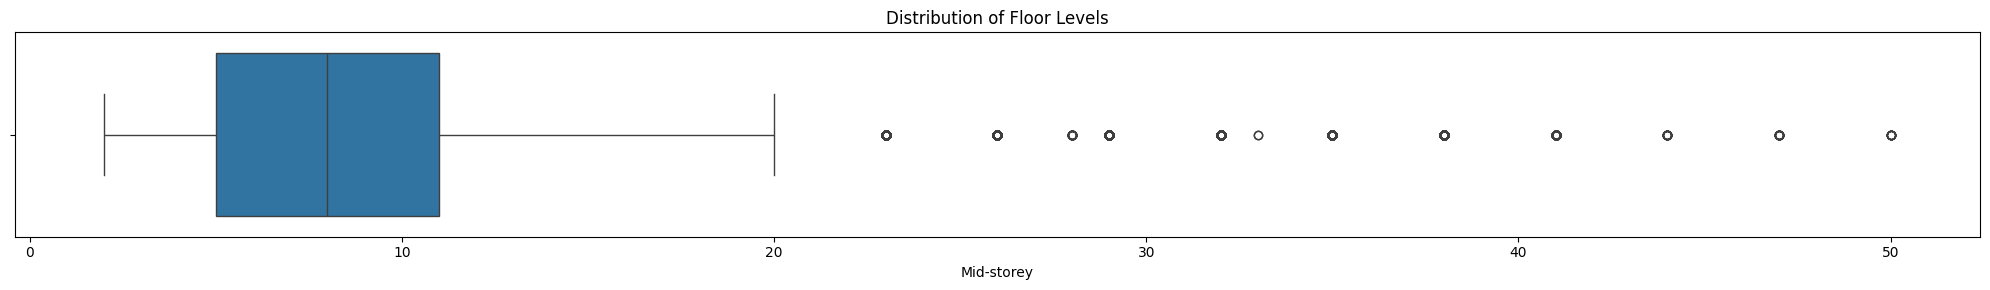

In [18]:
# Display: Distribution of Floor Levels
plt.figure(figsize=(20,3))
sns.boxplot(data=exploratory_train_df, x="mid")
plt.title("Distribution of Floor Levels")
plt.xlabel('Mid-storey')
plt.tight_layout()

<b>A-H3: Apartment's Structural/Interior Features are Positively Correlated with Resale Price </b>

<b>  EDA  </b>

1. Examine distribution of resale prices by "flat type-model"

    - Finding: There are models that have higher resale prices compared to their `flat_type`, and these relate to the following models:
    
        - "DBSS" models : apartments built by private developers, and were intended to have premium interiors [1]
        - "Terrace" models : akin to landed properties [2]
        - "Mansionette/Loft" : models: akin to 2-storey landed properties in the sky [3]
        - "Duxton S-types" : pinnacle@duxton flats known for their city-centre location and landmark architectural features [4]
    - We engineer indicator (dummy) variables for each of those flat types.
    
<font size="1.5">
<br>

- [1] Property Guru. (2023). HDB DBSS Flats in Singapore: Price Guide to All 13 DBSS Projects (2023). https://www.propertyguru.com.sg/property-guides/dbss-singapore-17893

- [2] Property Guru. (2021). HDB Terrace Houses: 6 of These Public Landed Properties Under 1 Million. https://www.propertyguru.com.sg/property-guides/cheap-hdb-terrace-house-under-850k-35237

- [3] 99.co. (2021). What’s the difference between HDB loft units and executive maisonettes? https://www.99.co/singapore/insider/difference-hdb-loft-executive-maisonettes/

- [4] National Library Board. (n.d). Launch of The Pinnacle@Duxton. https://www.nlb.gov.sg/main/article-detail?cmsuuid=156f0c70-8446-4386-ab34-e67de71a79ca

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42],
 [Text(0, 0, '1 ROOM Improved'),
  Text(1, 0, '2 ROOM 2-room'),
  Text(2, 0, '2 ROOM DBSS'),
  Text(3, 0, '2 ROOM Improved'),
  Text(4, 0, '2 ROOM Model A'),
  Text(5, 0, '2 ROOM Premium Apartment'),
  Text(6, 0, '2 ROOM Standard'),
  Text(7, 0, '3 ROOM DBSS'),
  Text(8, 0, '3 ROOM Improved'),
  Text(9, 0, '3 ROOM Model A'),
  Text(10, 0, '3 ROOM New Generation'),
  Text(11, 0, '3 ROOM Premium Apartment'),
  Text(12, 0, '3 ROOM Simplified'),
  Text(13, 0, '3 ROOM Standard'),
  Text(14, 0, '3 ROOM Terrace'),
  Text(15, 0, '4 ROOM Adjoined flat'),
  Text(16, 0, '4 ROOM DBSS'),
  Text(17, 0, '4 ROOM Improved'),
  Text(18, 0, '4 ROOM Model A'),
  Text(19, 0, '4 ROOM Model A2'),
  Text(20, 0, '4 ROOM New Generation'),
  Text(21, 0, '4 ROOM Premiu

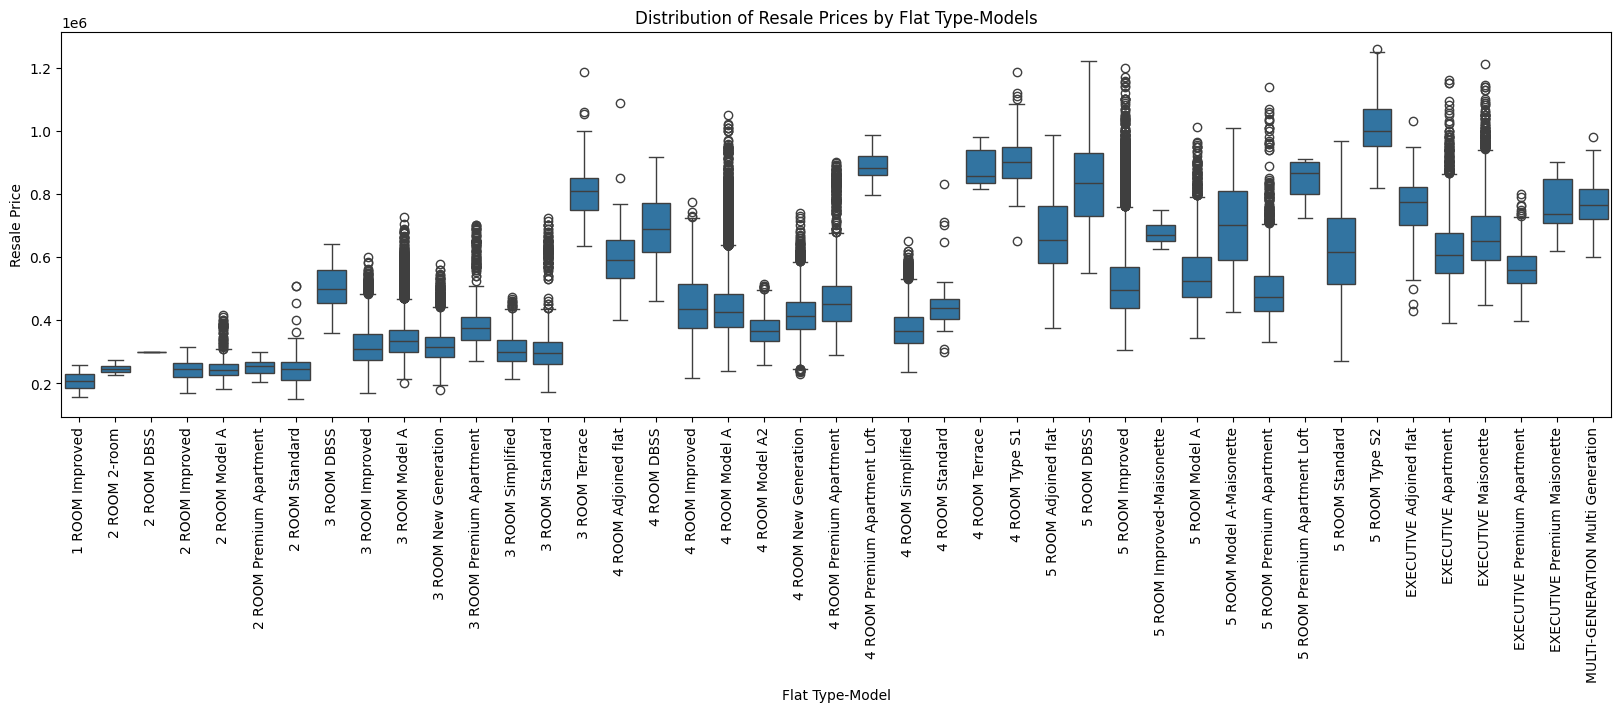

In [19]:
# Examine Distribution of Resale Prices by "flat type-model"

plt.figure(figsize=(20,5))
sns.boxplot(data=exploratory_train_df, y="resale_price", x="flat_type_model", order=flat_type_model_list)
plt.title("Distribution of Resale Prices by Flat Type-Models")
plt.xlabel('Flat Type-Model')
plt.ylabel('Resale Price')
plt.xticks(rotation=90)

---

<b> Feature Category - Apartment's :: Remaining Lease Period & Summary of EDA Findings</b>

- LP-H1: Apartment's Remaining Lease Period is Positively Correlated with Resale Price 

<b> LP-H1: Apartment's Remaining Lease Period is Positively Correlated with Resale Price </b>

<b>  EDA  </b>

1. Examine distribution of remaining lease period

    - Finding: min (44 yrs), median (70 yrs), max (97 yrs)

In [20]:
# Examine Distribution of Remaining Lease Period

exploratory_train_df["remaining_lease_yrs"] = 99 - exploratory_train_df["hdb_age"]

print("Sumstat: Remaining Lease Period (Years)\n")
print(exploratory_train_df["remaining_lease_yrs"].describe())

Sumstat: Remaining Lease Period (Years)

count    150634.000000
mean         70.448464
std          12.138829
min          44.000000
25%          62.000000
50%          70.000000
75%          79.000000
max          97.000000
Name: remaining_lease_yrs, dtype: float64


2. Examine relationship between remaining lease period and resale prices 

    - Finding: positive correlation (0.350), with wide variation in prices by remaining lease years - suggesting presence of other factors influencing resale prices

Correlation:
                      remaining_lease_yrs  resale_price
remaining_lease_yrs             1.000000      0.350337
resale_price                    0.350337      1.000000


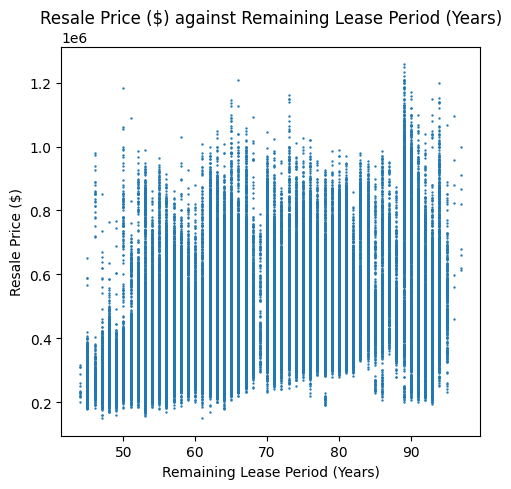

In [21]:
# Display: Relationship between Remaining Lease Period & Resale Price

plt.figure(figsize=(5,5))
plt.scatter(exploratory_train_df["remaining_lease_yrs"], exploratory_train_df["resale_price"], s=0.5)
plt.title("Resale Price ($) against Remaining Lease Period (Years)")
plt.ylabel("Resale Price ($)")
plt.xlabel("Remaining Lease Period (Years)")
plt.tight_layout()

print("Correlation:\n", exploratory_train_df[["remaining_lease_yrs","resale_price"]].corr())

<b> :: Data Cleaning : "Remaining Lease Years" :: </b>

1. Check for Missing Values
    - Finding : *No Missing Values*

2. Perform Logic Check
    - Finding : *max remaining lease years does not exceed 99 (the theoretical maximum)*

In [22]:
# Check: Missing Values
print("No. of missing values:", exploratory_train_df["remaining_lease_yrs"].isnull().sum())

# Check: Maximum Value of "Remaining Lease Years"
print("Maximum value:", exploratory_train_df["remaining_lease_yrs"].max())

No. of missing values: 0
Maximum value: 97


---

<b> Feature Category - Accessibility to Transport Infrastructure & Summary of EDA Findings </b>

- TI-H1: Nearest MRT station Within Walking Distance is Positively Correlated with Resale Price 

- TI-H2: Nearest MRT station being a Train Interchange is Positively Correlated with Resale Price 

- TI-H3: Nearest MRT station being a Bus Interchange is Positively Correlated with Resale Price

- TI-H4: Nearest Bus Stop within Close Proximity is Negatively Correlated with Resale Price

<b> TI-H1: Nearest MRT station Within Walking Distance is Positively Correlated with Resale Price </b>

<b>  EDA  </b>

1. Examine distribution of walking distances to the nearest MRT station

    - Finding : median (680m), 75th percentile (975m), max (~3,500km)
    - Assessment : uncertain how accessible these distances are; to feature engineer a "within walking distance" metric as a gauge of proximity

In [23]:
# Examine Distribution of Distance to Nearest MRT Station
print("Sumstat: Distance to Nearest MRT Station\n")
print(exploratory_train_df["mrt_nearest_distance"].describe())

Sumstat: Distance to Nearest MRT Station

count    150634.000000
mean        765.007872
std         429.366039
min          21.971410
25%         458.266301
50%         682.621343
75%         975.734180
max        3544.504228
Name: mrt_nearest_distance, dtype: float64


2. Examine relationship between walking distance to the nearest MRT station and resale prices

    - Finding (1) : negative correlation (-0.128), suggesting that closer proximity to an MRT station is associated with higher resale prices 
    - Finding (2) : wide variation in prices by distance to the nearest MRT station - suggesting presence of other factors influencing resale prices

Correlation:
                       mrt_nearest_distance  resale_price
mrt_nearest_distance              1.000000     -0.128222
resale_price                     -0.128222      1.000000


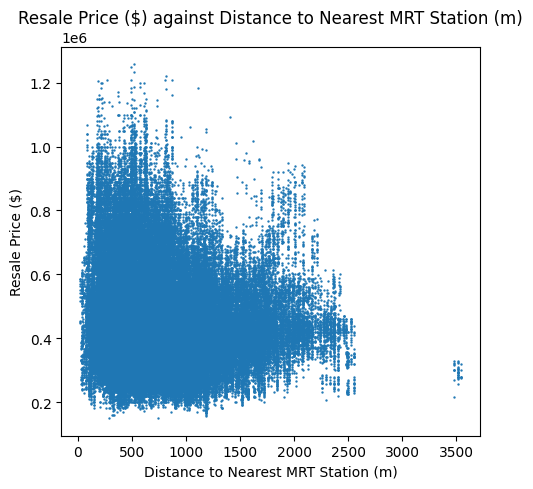

In [24]:
# Display: Relationship between Distance to Nearest MRT Station & Resale Price

plt.figure(figsize=(5,5))
plt.scatter(exploratory_train_df["mrt_nearest_distance"], exploratory_train_df["resale_price"], s=0.5)
plt.title("Resale Price ($) against Distance to Nearest MRT Station (m)")
plt.ylabel("Resale Price ($)")
plt.xlabel("Distance to Nearest MRT Station (m)")
plt.tight_layout()

print("Correlation:\n", exploratory_train_df[["mrt_nearest_distance","resale_price"]].corr())

<b> :: Feature Engineering :: </b>

1. Construct Dummy : Nearest MRT Station witin Walking Distance

    - Walking Distance Cutoff: 600m
    - Public transit planners typically assume that most users arrive and depart from transit stops via walking, and often define a catchment zone between 400-800m from a stop [1]
    - For our purposes, we'll thus use the mid-point of this range (=600m) as a "within walking distance" cutoff

<font size="1.5">

<br>

- [1] Durand et al. (2017). The Association of Trip Distance With Walking To Reach Public Transit: Data from the California Household Travel Survey. Journal of Transport & Health. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4941821/

<b> TI-H2, TI-H3 Nearest MRT Station being a Transport Hub is Positively Correlated with Resale Price  </b>

- TI-H2: Nearest MRT station being a Train Interchange is Positively Correlated with Resale Price 
- TI-H3: Nearest MRT station being a Bus Interchange is Positively Correlated with Resale Price

<b> :: EDA :: </b>

1. Examine relationship between nearest MRT station being a train / bus interchange and resale prices

    - Finding (1) : weak positive correlation (0.066), suggesting that MRT station being a <u>train</u> hub is associated with higher resale prices, albeit marginally 
    - Finding (2) : very weak positive correlation (0.002), suggesting that MRT station being a <u>bus</u> hub is associated with higher resale prices, albeit even less so

In [25]:
# Display: Relationship between Nearest MRT Station being a Train / Bus Interchange & Resale Price
print("\nCorrelation:\n", exploratory_train_df[["mrt_interchange","resale_price"]].corr())
print("\nCorrelation:\n", exploratory_train_df[["bus_interchange","resale_price"]].corr())


Correlation:
                  mrt_interchange  resale_price
mrt_interchange         1.000000      0.066413
resale_price            0.066413      1.000000

Correlation:
                  bus_interchange  resale_price
bus_interchange         1.000000      0.002547
resale_price            0.002547      1.000000


<b> TI-H4: Nearest Bus Stop within Close Proximity is Negatively Correlated with Resale Price </b>

<b>  EDA  </b>

1. Examine distribution of walking distances to the nearest bus stop

    - Finding : median (~100m), 75th percentile (~150m), max (~450m)
    - Assessment (1) : these distances all fall below within the walking distance cutoff of 600m used above (details under: section on walking distance to nearest MRT station)
    - Assessment (2) : to feature a "close proximity" cutoff instead

In [26]:
# Examine Distribution of Distance to Nearest Bus Stop
print("Sumstat: Distance to Nearest Bus Stop\n")
print(exploratory_train_df["bus_stop_nearest_distance"].describe())

Sumstat: Distance to Nearest Bus Stop

count    150634.000000
mean        115.258966
std          55.572855
min           9.001285
25%          75.032491
50%         107.765999
75%         146.652409
max         443.964584
Name: bus_stop_nearest_distance, dtype: float64


2. Examine relationship between walking distance to the nearest bus stop and resale prices

    - Finding (1) : weak positive correlation (0.031), suggesting that closer proximity to a bus stop is associated with lower resale prices (*)
        - (*) *the weak positive correlation could be due to homeowners' preference to stay further away from vehicular traffic that produces vehicular exhaust and noise*
    - Finding (2) : wide variation in prices by distance to the nearest bus stop - suggesting presence of other factors influencing resale prices

Correlation:
                            bus_stop_nearest_distance  resale_price
bus_stop_nearest_distance                    1.00000       0.03194
resale_price                                 0.03194       1.00000


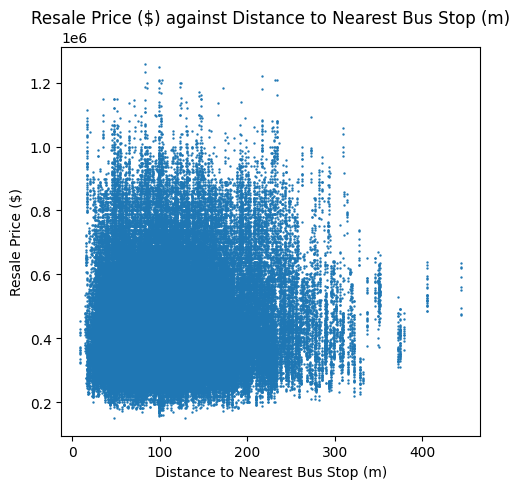

In [27]:
# Display: Relationship between Distance to Nearest Bus Stop & Resale Price

plt.figure(figsize=(5,5))
plt.scatter(exploratory_train_df["bus_stop_nearest_distance"], exploratory_train_df["resale_price"], s=0.5)
plt.title("Resale Price ($) against Distance to Nearest Bus Stop (m)")
plt.ylabel("Resale Price ($)")
plt.xlabel("Distance to Nearest Bus Stop (m)")
plt.tight_layout()

print("Correlation:\n", exploratory_train_df[["bus_stop_nearest_distance","resale_price"]].corr())

<b>  Feature Engineering  </b>

1. Construct Dummy : Nearest Bus Stop within Close Proximity

    - Close Proximity Cutoff: median distance (100m)

---

<b> Feature Category - Proximity to CBD & Summary of EDA Findings </b>

- MRT-H1: Ease of Travelling to the CBD via MRT is Positively Correlated with Resale Price
    - See section 3.2. for background and details of engineered feature `mrt_score` (lowest number of MRT stations to CBD)

---

<b> Feature Category - Accessibility to Amenities </b>

- AM-H1: Mall within Walking Distance is Positively Correlated with Resale Price

- AM-H2: Nearest Hawker Centre within Walking Distance is Positively Correlated with Resale Price

<b> AM-H1: Mall within Walking Distance is Positively Correlated with Resale Price </b>

<b>  EDA  </b>

1. Examine distribution of walking distances to the nearest mall

    - Finding : median (~600m), 75th percentile (~870m), max (~3500m)
    - Assessment (1) : the median distance falls within the walking distance cutoff of 600m used above (details under: section on walking distance to nearest MRT station)
    - Assessment (2) : to feature engineer a "nearest mall within walking distance" variable as a predictor of resale prices

In [28]:
# Examine Distribution of Distance to Nearest Mall
print("Sumstat: Distance to Nearest Mall\n")
print(exploratory_train_df["mall_nearest_distance"].describe())

Sumstat: Distance to Nearest Mall

count    149805.000000
mean        664.239826
std         368.739209
min           0.000000
25%         391.473823
50%         602.818388
75%         868.818288
max        3496.402910
Name: mall_nearest_distance, dtype: float64


2. Examine relationship between distance to the nearest mall and resale prices

    - Finding (1) : weak negative correlation (-0.087), suggesting that a longer distance away from the nearest mall is associated with lower resale prices
    - Finding (2) : wide variation in prices by distance away from the nearest mall - suggesting presence of other factors influencing resale prices

Correlation:
                        mall_nearest_distance  resale_price
mall_nearest_distance               1.000000     -0.087096
resale_price                       -0.087096      1.000000


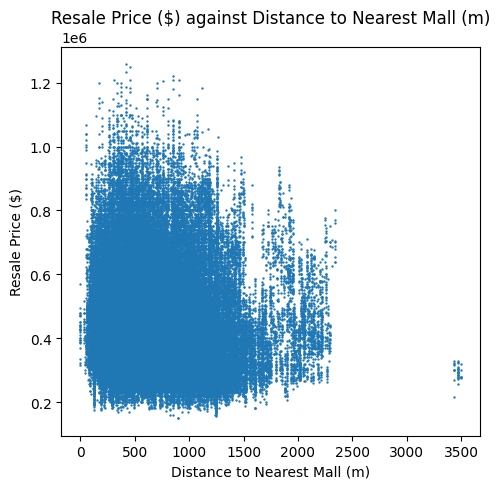

In [29]:
# Display: Relationship between Distance to Nearest Mall & Resale Price

plt.figure(figsize=(5,5))
plt.scatter(exploratory_train_df["mall_nearest_distance"], exploratory_train_df["resale_price"], s=0.5)
plt.title("Resale Price ($) against Distance to Nearest Mall (m)")
plt.ylabel("Resale Price ($)")
plt.xlabel("Distance to Nearest Mall (m)")
plt.tight_layout()

print("Correlation:\n", exploratory_train_df[["mall_nearest_distance","resale_price"]].corr())

<b>  Data Cleaning : "Distance to Nearest Mall"  </b>

1. Check for Missing Values

    - Finding : *829 observations with missing values*
    - Assessment : Impute with engineered distance calculations from imported external mall latitude/longitude data.
        - See section 3.2. for details and background

In [30]:
# Check: Missing Values
print("No. of missing values:", exploratory_train_df["mall_nearest_distance"].isnull().sum())

No. of missing values: 829


<b>  Feature Engineering  </b>

1. Construct Dummy : Nearest Mall within Walking Distance

    - Walking Distance Cutoff: 600m  (details under: section on walking distance to nearest MRT station)

<b> AM-H2: Hawker Centre within Walking Distance is Positively Correlated with Resale Price </b>

<b>  EDA  </b>

1. Examine distribution of walking distances to the nearest hawker centre

    - Finding : median (~780m), 75th percentile (~1700m), max (~4900m)
    - Assessment (1) : the median distance falls slightly above the walking distance cutoff of 600m used above (details under: section on walking distance to nearest MRT station)
    - Assessment (2) : to feature engineer a "nearest hawker centre within walking distance" variable as a predictor of resale prices

In [31]:
# Examine Distribution of Distance to Nearest Hawker Centre
print("Sumstat: Distance to Nearest Hawker Centre\n")
print(exploratory_train_df["hawker_nearest_distance"].describe())

Sumstat: Distance to Nearest Hawker Centre

count    150634.000000
mean       1173.700148
std        1076.701337
min           1.873295
25%         372.132398
50%         778.966980
75%        1678.949229
max        4907.036414
Name: hawker_nearest_distance, dtype: float64


2. Examine relationship between distance to the nearest hawker centre and resale prices

    - Finding (1) : weak negative correlation (-0.014), suggesting that a longer distance away from the nearest hawker centre is associated with lower resale prices
    - Finding (2) : wide variation in prices by distance away from the nearest hawker centre - suggesting presence of other factors influencing resale prices

Correlation:
                          hawker_nearest_distance  resale_price
hawker_nearest_distance                 1.000000     -0.014537
resale_price                           -0.014537      1.000000


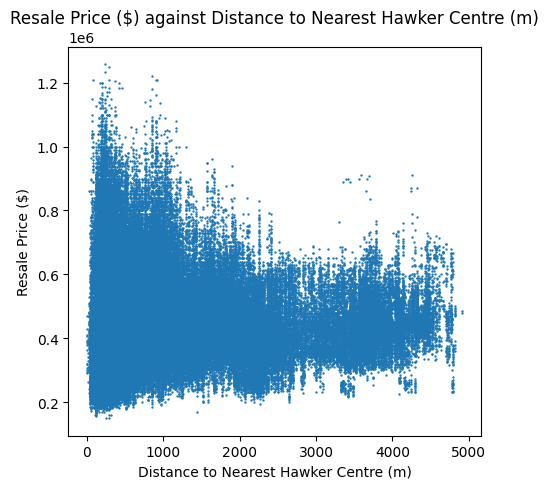

In [32]:
# Display: Relationship between Distance to Nearest Hawker Centre & Resale Price

plt.figure(figsize=(5,5))
plt.scatter(exploratory_train_df["hawker_nearest_distance"], exploratory_train_df["resale_price"], s=0.5)
plt.title("Resale Price ($) against Distance to Nearest Hawker Centre (m)")
plt.ylabel("Resale Price ($)")
plt.xlabel("Distance to Nearest Hawker Centre (m)")
plt.tight_layout()

print("Correlation:\n", exploratory_train_df[["hawker_nearest_distance","resale_price"]].corr())

<b> :: Feature Engineering :: </b>

1. Construct Dummy : Nearest Hawker Centre within Walking Distance

    - Walking Distance Cutoff: 600m  (details under: section on walking distance to nearest MRT station)

---

<b> Feature Category - Unobserved Area Characteristics  </b>

- `planning_area` is a more granular geographic unit than `town`
- We use the less-granular `town` variable instead to reduce the impact of too many factors on a too-granular scale.

---

# 3. Outline of Data Processing and Analysis

Our full data processing pipeline should proceed as follows:

### 3.1. Data Cleaning

<details><summary>The cleaning steps (excluding imputing) are as follows:</summary>

- Standardize all the column names to be fully lowercase and separated by underscores.
- We convert `tranc_year`, `tranc_month` to strings.
</details>

### 3.2. Feature Engineering

<details><summary>The following features are specially engineered from existing columns, see implementation for details:</summary>

- Use Dijkstra's algorithm to get `mrt_score`. 
    - This uses `mrt_name`.
- Use the Haversine formula to get `nearest_brand_pri_sch`, `brand_pri_sch_within_1km`, `brand_pri_sch_within_2km`. `nearest_brand_sec_sch`, `brand_sec_sch_within_1km`, `brand_sec_sch_within_2km`. 
    - This uses `latitude`, `longitude`, `pri_sch_latitude`, `pri_sch_longitude`, `sec_sch_latitude`, `sec_sch_longitude`.
- Use the Haversine formula to imput `mall_nearest_distance`, `mall_within_500m`, `mall_within_1km`, `mall_within_2km`.
    - This uses `latitude` and `longitude`, along with a separate dataset `shopping_mall_coordinates.csv`.
- Change the target variable from `resale_price` to `price_per_sqm`.
    - This is computed as `resale_price / floor_area_sqm`.
- `hawker_within_500m`, `bus_stop_within_100m` and `mrt_within_500m` as indicators of "walking distance"
- Replace `full_flat_type` with dummies for `terrace`, `dbss`, `mansionette_loft`, `duxton_S1_S2`
- Calculate `remaining_lease_years` (`99 - (tranc_year - lease_commence_date)`)
</details>

### 3.3. Dropping Columns

<details><summary>There are two main reasons for dropping the following columns - either they are redundant or they are already engineered to a more useful variable:</summary>

- Redundant / highly-correlated columns to be dropped are:

|Column name(s)|Reason for dropping|
|---|---|
|`tranc_yearmonth`|info in `tranc_year` and `tranc_month` columns|
|`storey-range`|info in `lower`, `mid`, `upper` columns|
|`mid_storey`|exact same values as `mid`|
|`lower`, `upper`|highly correlated with `mid`|
|`residential`|only has one value|
|`floor_area_sqft`|dropped to prevent artificial dependency, use only `floor_area_sqm` instead|
|`address`, `block` and `street_name`|hard to interpret|
|`flat_type`|info in `full_flat_type`|
|`planning_area`, `postal`|highly correlated with `town`|
|`block`, `street_name`|hard to interpret|
|`year_completed`|high correlation with `lease_commence_date`|
|`total_dwelling_units`|sum of unit-related features - perfectly correlated|
|`hawker` columns, except for `hawker_within_500m`|keep that as a measure of "within walking distance"|

- Engineered columns to be dropped are
    - `mrt_name`
    - `bus_stop_name`
    - `pri_sch_name`, `pri_sch_nearest_distance`
    - `sec_sch_name`, `sec_sch_nearest_distance`
    - All columns with `latitude` and `longitude` (highly correlated because of the small range)
    - `resale_price` (can be recovered in test data using `price_per_sqm * floor_area_sqm`)
    - `hdb_age`, `lease_commence_date` (replace with `remaining_lease_years = 99 - (tranc_year - lease_commence_date)`)
    - `bus_stop_nearest_distance`, `mrt_nearest_distance` (replaced with dummies `~_within_100m/500m` as a measure of "within walking distance")
    - `full_flat_types` (replaced with dummies for `terrace`, `dbss`, `mansionette_loft`, `duxton_S1_S2`)
</details>


### 3.4. Pipelines

In order to shape our data to make the model as predictive as possible, we would need to split our variables up into a few categories:

### Numeric Variables

<details><summary>This should be self-explanatory: numeric variables are simply variables with a datatype of either integer or float.</summary>

Our numeric variables are the remaining ones that are selected by `df.select_dtypes(np.number)`, excluding the following:
- `id`
- `resale_price`

These excluded numerical variables should go into a temporary holding DataFrame for later use. Specifically, `resale_price` is our target variable, and we would need `id` for final submission. 

Meanwhile, the rest of the numeric variables will undergo imputing with `SimpleImputer()`, and then scaling with `StandardScaler()`.
</details>

### Categorical Variables

<details><summary>These are variables that take on a discrete finite set of non-numerical values. As one-hot encoding does not perform as well when there are too many categorical values in a variable, we partition them into two subsets - high-cardinality (>255 categories) and low-cardinality (<= 255 cardinalities). However, due to being difficult to interpret, the high-cardinality variables will be dropped.</summary>


### Low-cardinality categorical variables

The low-cardinality categorical variables are as follows:
- `town`
- `tranc_year`
- `tranc_month`

These will undergo one-hot encoding with `OneHotEncoder()`.
</details>

All variables will then go through a regression model to be decided in section 4.

# Importing the data

In [34]:
init_train_df = pd.read_csv('data/train.csv')

C:\Users\Aspire\AppData\Local\Temp\ipykernel_6148\493356928.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  init_train_df = pd.read_csv('data/train.csv')


# Helper Functions

In [35]:
def flatten(lst_of_lsts):
    '''Flattens a list of lists `lst_of_lsts`.'''
    return [elem for lst in lst_of_lsts for elem in lst]

def distinct_elems(lst):
    '''Returns a list of distinct elements from a given list `lst`.'''
    return list(set(lst))

def shortest_lists(lst_of_lists):
    '''Helper function to find the shortest list(s) in a list of lists'''
    if lst_of_lists: # checks that lst_of_lists is not empty

        # initializes list of same-length lists
        current_list = []
        
        for lst in lst_of_lists:

            # adds to current list if current list is empty or the lengths are the same
            if not current_list or len(lst) == len(current_list[0]):
                current_list.append(lst)
            
            # else replaces the entire list with shorter candidates
            elif len(lst) < len(current_list[0]):
                current_list = [lst]

        return current_list
    return []

def filter_dict(dic, lst_of_keys):
    '''Outputs a filtered subset of the dictionary `dic` with only keys in `lst_of_keys`
    '''
    filtered_dic = {key: val for key, val in dic.items() if key in lst_of_keys}

    return filtered_dic

def exclude_cols(df, cols):
    '''Returns a DataFrame with columns from `cols` excluded.
    
    Parameters:
    - `df`: The DataFrame to be operated on
    - `cols`: List of names of columns to exclude'''
    return df[df.columns[~df.columns.isin(cols)]].copy()

# 3.1. Data Cleaning

We abstract out the cleaning that we outlined in section 2 and the intro to section 3 into a function `cleaner()`.

In [36]:
def cleaner(dataframe):
    '''Performs an initial cleaning of `dataframe`.

    - Lowercase all column names
    - Converts `tranc_year` and `tranc_month` to strings 
    '''
    
    # standardize all column names to be lowercase and separated by underscores
    dataframe.rename(str.lower, axis='columns', inplace=True)

    # converting tranc_year and tranc_month to strings
    for col in ['tranc_year', 'tranc_month']:
        dataframe[col] = [str(val) for val in dataframe[col].values]
    
    return dataframe

# 3.2. Feature Engineering

The following features shall be engineered:

|Feature|Method|
|---|---|
|`bus_stop_within_100m`|Dummy based on `bus_stop_nearest_distance`|
|`mrt_within_500m`|Dummy based on `mrt_nearest_distance`|
|`is_terrace`|Dummy based on `full_flat_type`|
|`is_dbss`|Dummy based on `full_flat_type`|
|`is_mansionette_or_loft`|Dummy based on `full_flat_type`|
|`is_duxton_S1_S2`|Dummy based on `full_flat_type`|
|`mrt_score`|Minimum number of MRT stations to Central Business District; Uses Dijkstra's algorithm on `mrt_name`|
|`nearest_brand_pri_sch`, `brand_pri_sch_within_0-1km`, `brand_pri_sch_within_1-2km`|Uses the Haversine formula on `latitude`, `longitude`, and data from [The Children's Society](https://www.childrensociety.org.sg/wp-content/uploads/2022/07/Schools-and-Class-Divide_Research-Monograph-11_FINAL_24-Aug-2016v3.pdf)|
|`nearest_brand_sec_sch`, `brand_sec_sch_within_0-1km`, `brand_sec_sch_within_1-2km`|Uses the Haversine formula on `latitude`, `longitude`, and data from [The Children's Society](https://www.childrensociety.org.sg/wp-content/uploads/2022/07/Schools-and-Class-Divide_Research-Monograph-11_FINAL_24-Aug-2016v3.pdf)|
|`price_per_sqm`|`resale_price / floor_area_sqm`|
|`remaining_lease_years`|`99 - (tranc_year - lease_commence_date)`|

### Converting existing columns to indicator variables

In [37]:
def insert_dummy_cols(dataframe):
    '''Inserts the indicator columns (walking distance, and flat type) that we want to look at.
    '''

    # bus stop within walking distance
    dataframe['bus_stop_within_100m'] = (dataframe['bus_stop_nearest_distance'] <= 100).astype(int)

    # mrt within walking distance
    dataframe['mrt_within_500m'] = (dataframe['mrt_nearest_distance'] <= 500).astype(int)

    # flat type dummies
    dataframe['is_terrace'] = (dataframe['full_flat_type'].str.contains('Terrace')).astype(int)
    dataframe['is_dbss'] = (dataframe['full_flat_type'].str.contains('DBSS')).astype(int)
    dataframe['is_maisonette_or_loft'] = (dataframe['full_flat_type'].str.contains('Maisonette') | 
                                          dataframe['full_flat_type'].str.contains('Loft')).astype(int)
    dataframe['is_duxton_S1_S2'] = (dataframe['full_flat_type'].str.contains('Type S1') | 
                                    dataframe['full_flat_type'].str.contains('Type S2')).astype(int)

    return dataframe

### MRT features

This section uses [Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) to calculate the `mrt_score` as the minimum number of stations traversed in the shortest path between the station `mrt_name` and a "CBD station".

The implementation of the algorithm is credited to Eryk Kopczyński, code referenced from [here](https://www.python.org/doc/essays/graphs/), and uses a [deque](https://docs.python.org/3/library/collections.html#collections.deque) from Python's `collections` module for efficient breadth-first search.

"CBD stations" are defined as follows:

|Line|Station(s)|
|---|---|
|NSL|Raffles Place, City Hall, Marina Bay|
|EWL|Outram Park, Tanjong Pagar, Raffles Place, City Hall|
|CCL|Telok Blangah, Harbourfront, Bayfront, Promenade, Esplanade, Marina Bay|
|DTL|Telok Ayer, Downtown, Bayfront, Promenade|
|TEL|Maxwell, Shenton Way, Marina Bay|

In [38]:
def insert_mrt_score_column(dataframe):
    '''Inserts `mrt_score` column into `dataframe`.
    '''
    dataframe['mrt_score'] = dataframe.apply(lambda row: mrt_scores_per_station[row['mrt_name']], axis=1)

    return dataframe

### Latitude and Longitude Features (Malls and Branded Schools)

We would also like to make use of the latitude and longitude to engineer features regarding the proximity of malls and "branded" schools.

<details><summary>Mathematical background of latitude and longitude calculations:</summary>

As is common knowledge since the circumnavigation of the Earth by the Magellan Expedition in 1519-1522, the Earth is not flat. However, modeling the Earth as a perfect sphere isn't exactly correct either, as the actual [shape of the Earth](https://en.wikipedia.org/wiki/Figure_of_the_Earth) is an oblate spheroid, and an imperfect one at that. 

This makes [measuring](https://en.wikipedia.org/wiki/Geographical_distance) exact distances on the surface of the Earth slightly challenging, and is one of the major problems that the creators of the Global Positioning System (GPS) had to solve.

Even more troubling, while relatively small distances on the surface of the Earth would be reasonably approximated to a small margin of error by using the Pythagorean theorem as the Earth is locally approximated by a flat plane, said theorem only works if the points given are Cartesian coordinates $p_1=(x_1, y_1)$ and $p_2=(x_2, y_2)$. The Pythagorean distance would then be given by $$d(p_1,p_2)=\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}$$ That is not the case here, as we are given latitude and longitude, which assume that we are working in spherical coordinates. 

Specifically, the point with latitude $\phi$ and longitude $\lambda$ would correspond to the Cartesian coordinates $$(r\cos(\phi)\cos(\lambda),\ r\cos(\phi)\sin(\lambda),\ r\sin(\phi))$$ on the sphere with radius $r$ in 3-dimensional Euclidean space. On the sphere, the shortest distance between two points would be computed instead by the [great circle distance](https://en.wikipedia.org/wiki/Great-circle_distance), the distance along the great circle on the sphere that connects the two points.

A relatively efficient computation for the great circle distance between two points specified by latitude and longitude is achieved by the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula), which work just fine when two points are close to each other on the sphere, as is per our case for Singapore.

Assuming that the latitudes and longitudes are all given in radians, the Haversine formula for the distance $d$ between two points on the sphere with radius $r$ given by latitudes and longitudes $p_1=(\phi_1, \lambda_1)$ and $p_2=(\phi_2, \lambda_2)$ is given as follows: $$d(p_1, p_2)=r\cdot\left(2\tan^{-1}\left(\frac{\sqrt{a}}{\sqrt{1-a}}\right)\right)$$ where $$a=\frac{1-\cos(\phi_2-\phi_1)}{2}+\cos(\phi_1)\cos(\phi_2)\left(\frac{1-\cos(\lambda_2-\lambda_1)}{2}\right)$$ is called the [haversine](https://en.wikipedia.org/wiki/Versine) (or half a versine). 

This may seem a tad complicated, but it essentially just uses the arc-length formula $d=r\theta$, and that the computation of $\theta$ is only more involved due to the inputs being latitude and longitude.
</details>

In [39]:
# implementation of the Haversine formula

def haversine_dist(lat_1, long_1, lat_2, long_2, r=6371):
    '''Computes the great circle distance between two points `(lat_1, long_1)` and `(lat_2, long_2)` 
    on a spherical Earth, specified by latitudes `lat_1`, `lat_2` and longitudes `long_1`, `long_2`.

    Parameters
    ----------
    `lat_1`: float
        Latitude of the first point in degrees
    `long_1`: float
        Longitude of the first point in degrees
    `lat_2`: float
        Latitude of the second point in degrees
    `long_2`: float
        Longitude of the second point in degrees
    `r`: float
        Radius of the Earth. Default `6371` km.

    Returns
    -------
    `dist`: float
        Distance between the two points in km.
    '''

    # converts all latitudes and longitudes to radians
    lat_1, long_1, lat_2, long_2 = np.radians(lat_1), np.radians(long_1), np.radians(lat_2), np.radians(long_2)

    # calculates latitude and longitude differences
    dlat = lat_2 - lat_1
    dlong = long_2 - long_1

    # calculates the haversine
    haversine = 0.5 * (1 - np.cos(dlat) + np.cos(lat_1)*np.cos(lat_2)*(1 - np.cos(dlong)))

    # calculates the great circle distance
    dist = 2 * r * np.arctan2(np.sqrt(haversine), np.sqrt(1 - haversine))

    return dist

###########################################################

# test cases
haversine_dist(1.317659, 103.882504, 1.350110, 103.854892)

4.737317280471989

### Branded Schools

We first jump-start our table of schools and their coordinates by extracting the relevant data from the dataframe. We then manually fill in the remaining coordinates for the missing "branded" schools not in the dataframe.

In [40]:
# isolates the primary school names and their relevant coordinates to a dictionary
pri_sch_dict = init_train_df.loc[:,['pri_sch_name', 'pri_sch_latitude', 'pri_sch_longitude']].to_dict(orient='list')

# isolates the secondary school names and their relevant coordinates to a dictionary
sec_sch_dict = init_train_df.loc[:,['sec_sch_name', 'sec_sch_latitude', 'sec_sch_longitude']].to_dict(orient='list')

# matches up the schools with their coordinates
lst_of_pri_sch_coords = zip(pri_sch_dict['pri_sch_latitude'], pri_sch_dict['pri_sch_longitude'])
lst_of_sec_sch_coords = zip(sec_sch_dict['sec_sch_latitude'], sec_sch_dict['sec_sch_longitude'])

pri_sch_coords = {name: coords for name, coords in zip(pri_sch_dict['pri_sch_name'], lst_of_pri_sch_coords)}
sec_sch_coords = {name: coords for name, coords in zip(sec_sch_dict['sec_sch_name'], lst_of_sec_sch_coords)}

pri_sch_coords

{'Geylang Methodist School': (1.317658971, 103.8825037),
 'Kuo Chuan Presbyterian Primary School': (1.349783074, 103.8545292),
 'Keming Primary School': (1.3452450530000002, 103.7562645),
 'Catholic High School': (1.3547888769999998, 103.8449341),
 'Naval Base Primary School': (1.4162801530000002, 103.8387977),
 "Saint Margaret's Primary School": (1.324469751, 103.8816233),
 'Xinmin Primary School': (1.371414726, 103.8830391),
 'Damai Primary School': (1.335351315, 103.9212683),
 'Ai Tong School': (1.360736365, 103.8330757),
 'Anchor Green Primary School': (1.390662478, 103.8872561),
 'North Vista Primary School': (1.382893394, 103.8958542),
 'Tampines North Primary School': (1.36069172, 103.9489368),
 'Rosyth School': (1.372915796, 103.8746932),
 'Alexandra Primary School': (1.291299035, 103.8239408),
 'Beacon Primary School': (1.384236677, 103.77375440000002),
 'Zhenghua Primary School': (1.379802361, 103.7691708),
 'Fuchun Primary School': (1.430639768, 103.7781752),
 'Guangyang Pri

In [41]:
# adding in coordinates of relevant missing "branded" schools

pri_sch_coords["Anglo-Chinese School"] = (1.31875235, 103.835076922932)
pri_sch_coords["Raffles Girls' Primary School"] = (1.33004178, 103.806397828938)
pri_sch_coords["Singapore Chinese Girls' School"] = (1.3210897, 103.827867312987)
pri_sch_coords["Methodist Girls' School"] = (1.3329500, 103.7825694)

sec_sch_coords["Nanyang Girls' High School"] = (1.3305, 103.8024)
sec_sch_coords["Hwa Chong Institution"] = (1.32654, 103.803491)
sec_sch_coords["Saint Joseph's Institution"] = (1.3236, 103.8273)
sec_sch_coords["National Junior College"] = (1.330278, 103.804167)
sec_sch_coords["NUS High School"] = (1.306911, 103.769356)
sec_sch_coords["Singapore Chinese Girls' School"] = (1.3210897, 103.827867312987)
sec_sch_coords["Victoria School"] = (1.308575, 103.927467)
sec_sch_coords["Maris Stella High School"] = (1.3421839569999998, 103.8780964)
sec_sch_coords["Tanjong Katong Girls' School"] = (1.30785, 103.89619)

sec_sch_coords

{'Geylang Methodist School': (1.317658971, 103.8825037),
 'Kuo Chuan Presbyterian Secondary School': (1.350109648, 103.8548917),
 'Yusof Ishak Secondary School': (1.3423337780000002, 103.7600131),
 'Catholic High School': (1.3547888769999998, 103.8449341),
 'Orchid Park Secondary School': (1.414888187, 103.8383349),
 'Bowen Secondary School': (1.370751073, 103.877459),
 'Damai Secondary School': (1.33754548, 103.9264171),
 'Peirce Secondary School': (1.366131676, 103.8299104),
 'Nan Chiau High School': (1.388687442, 103.8902862),
 'Seng Kang Secondary School': (1.38609933, 103.8983931),
 'Pasir Ris Secondary School': (1.354639566, 103.9486147),
 'Serangoon Garden Secondary School': (1.369890484, 103.8691497),
 'Gan Eng Seng School': (1.289071145, 103.8237337),
 'Zhenghua Secondary School': (1.388197023, 103.7652523),
 'Fajar Secondary School': (1.375565392, 103.7638819),
 'Fuchun Secondary School': (1.430833988, 103.777148),
 'Guangyang Secondary School': (1.344673253, 103.8505502),
 '

We manually create a list of "branded" primary and secondary schools based on a study done by [Singapore Children's Society](https://www.childrensociety.org.sg/wp-content/uploads/2022/07/Schools-and-Class-Divide_Research-Monograph-11_FINAL_24-Aug-2016v3.pdf).

In [42]:
branded_pri_schs = ['Anglo-Chinese School',
                    'Catholic High School',
                    "CHIJ Saint Nicholas Girls' School",
                    'Henry Park Primary School',
                    'Nanyang Primary School',
                    "Raffles Girls' Primary School",
                    'Rosyth School',
                    "Singapore Chinese Girls' School",
                    "Saint Hilda's Primary School",
                    "Saint Joseph's Institution Junior",
                    "Saint Stephen's School",
                    'Tao Nan School',
                    'Ai Tong School',
                    'Canossa Catholic Primary School',
                    'CHIJ',
                    'CHIJ Our Lady of Good Counsel',
                    'CHIJ Our Lady of The Nativity',
                    'CHIJ Our Lady Queen of Peace',
                    'Chongfu School',
                    'De La Salle School',
                    'Fairfield Methodist School',
                    'Geylang Methodist School',
                    "Holy Innocents' Primary School",
                    'Hong Wen School',
                    'Kheng Cheng School',
                    'Kong Hwa School',
                    'Kuo Chuan Presbyterian Primary School',
                    'Maha Bodhi School',
                    'Maris Stella High School',
                    'Marymount Convent School',
                    'Mee Toh School',
                    'Nan Chiau Primary School',
                    'Ngee Ann Primary School',
                    "Paya Lebar Methodist Girls' School",
                    'Pei Chun Public School',
                    'Pei Hwa Presbyterian Primary School',
                    'Poi Ching School',
                    'Red Swastika School',
                    "Saint Andrew's Junior School",
                    "Saint Anthony's Canossian Primary School",
                    "Saint Gabriel's Primary School",
                    "Saint Margaret's Primary School"]


branded_sec_schs = ['Anglo-Chinese School',
                    'Catholic High School',
                    "Cedar Girls' Secondary School",
                    "CHIJ Saint Nicholas Girls' School",
                    'Dunman High School',
                    'Hwa Chong Institution',
                    "Methodist Girls' School",
                    "Nanyang Girls' High School",
                    'National Junior College',
                    'NUS High School',
                    'Raffles Institution',
                    "Raffles Girls' School",
                    'River Valley High School',
                    "Singapore Chinese Girls' School",
                    "Saint Joseph's Institution",
                    'Temasek Junior College',
                    'Victoria School',
                    'Anderson Secondary School',
                    'Anglican High School',
                    'Bukit Panjang Government High School',
                    'CHIJ Katong Convent',
                    'CHIJ Secondary',
                    'Chung Cheng High School',
                    'Commonwealth Secondary School',
                    "Crescent Girls' School",
                    'Dunman Secondary School',
                    'Fairfield Methodist School',
                    'Maris Stella High School',
                    'Nan Hua High School',
                    'Ngee Ann Secondary School',
                    "Paya Lebar Methodist Girls' School",
                    "Saint Anthony's Canossian Secondary School",
                    "Saint Hilda's Secondary School",
                    "Saint Margaret's Secondary School",
                    "Tanjong Katong Girls' School",
                    'Tanjong Katong Secondary School',
                    'Temasek Secondary School',
                    'Xinmin Secondary School',
                    'Yishun Town Secondary School',
                    'Zhonghua Secondary School']

### Malls

Now that we have the machinery to work with latitudes and longitudes, we can also use the `haversine_dist` function defined above to find the closest mall to each of the flats with null values in the `mall_nearest_distance` column.

In order to do that, we need a lookup table of the malls in Singapore, along with their latitudes and longitudes. To save time, we shall obtain the relevant data from [Kaggle](https://www.kaggle.com/datasets/karthikgangula/shopping-mall-coordinates) (let us trust the source for now) as a `.csv`, which we then import as DataFrame. 

In order to more easily work with it, we shall reshape it into a dictionary `mall_coords` with key-value pairs `mall_name: (latitude, longitude)`, similar to what we did for the schools above.

In [44]:
# importing a dataframe of malls and their coordinates
mall_df = pd.read_csv('data/shopping_mall_coordinates.csv')

# extracting the information in a dictionary
# format is mall_name: (latitude, longitude)
mall_coords = dict(zip(mall_df['Mall Name'].tolist(),
                       zip(mall_df['LATITUDE'].tolist(),
                           mall_df['LONGITUDE'].tolist())))

mall_coords

{'100 AM': (1.27458821795426, 103.84347073661),
 '313@Somerset': (1.30101436404056, 103.838360664485),
 'Aperia': (1.3104736675734, 103.86431321816),
 'Balestier Hill Shopping Centre': (1.32559594839311, 103.842571612968),
 'Bugis Cube': (1.2981408343975, 103.855635339249),
 'Bugis Junction': (1.29911287475873, 103.855411173758),
 'Bugis+': (1.30095171530648, 103.855172625542),
 'Capitol Piazza': (1.29307884763132, 103.851261982149),
 'Cathay Cineleisure Orchard': (1.30146393496315, 103.836463810773),
 'The Centrepoint': (1.30145045537088, 103.840034074858),
 'City Square Mall': (1.3113827185663, 103.856626855768),
 'CityLink Mall': (1.29260349413333, 103.854316064564),
 'Duo': (1.29953434891664, 103.85840168774),
 'Far East Plaza': (1.30730468891062, 103.833818438639),
 'Funan': (1.29134759697794, 103.849989790085),
 'Great World City': (1.29342272650003, 103.832022146655),
 'HDB Hub': (1.33201387005935, 103.84984949662),
 'ION Orchard': (1.30399286856099, 103.831988903795),
 'Junctio

### Computing Distance-based Features

As we would essentially be doing the same thing to compute distances for both malls and branded schools, we shall abstract out the process into a function `nearest_landmarks()` for better flexibility and elegance.

In [45]:
@functools.cache
def nearest_landmarks(lat, long, landmark='pri', radius=1.0, output='landmarks'):
    '''
    Parameters
    ----------
    `lat`: float
        Latitude of the selected point
    `long`: float
        Longitude of the selected point
    `landmark`: string. Default `'pri'`
        `'pri'`: Primary schools
        `'brand_pri'`: Branded primary schools
        `'sec'`: Secondary schools
        `'brand_sec'`: Branded secondary schools
        `'mall'`: Malls
    `radius`: float
        Search radius in km. Default `1.0` km
    `output`: string. Default `'landmarks'`
        `'landmarks'`: Outputs a list of `landmark`s that are within a `dist` km radius around `(lat, long)`
        `'count'`: Outputs how many `landmark`s there are within a `dist` km radius around `(lat, long)`
        `'data'`: Outputs a dictionary of `dist: landmarks` pairs 
        `'shortest'`: Outputs the shortest distance in metres to the nearest `landmark`, sets `radius` parameter to 100
    '''
    
    # radius switch
    if output == 'shortest':
        radius = 100.0

    # initializes empty output dictionary
    dist_landmarks = {}

    # initializes list of landmarks
    lst_landmarks = []

    # for conveniently switching between the different landmark types without using if-else statements
    landmark_switch = {'pri': pri_sch_coords,
                       'brand_pri': filter_dict(pri_sch_coords, branded_pri_schs),
                       'sec': sec_sch_coords,
                       'brand_sec': filter_dict(sec_sch_coords, branded_sec_schs),
                       'mall': mall_coords}
    
    for building in landmark_switch[landmark]:
        # retrieves the coordinates from the respective dictionary
        landmark_lat, landmark_long = landmark_switch[landmark][building]

        # computes the distance to 5 decimal places
        dist = np.round(1000*haversine_dist(lat, long, landmark_lat, landmark_long), 5)

        if dist <= 1000*radius:
            # appends the respective building to the output list
            lst_landmarks.append(building)

            if dist not in dist_landmarks:
                # adds the school name if there's no school with that distance away
                dist_landmarks[dist] = [building]
            else:
                # else appends to the current list value
                dist_landmarks[dist].append(building)
    
    # sorts dist_landmarks by distance
    dist_landmarks = dict(sorted(dist_landmarks.items()))

    if output == 'landmarks':
        return lst_landmarks

    if output == 'count':
        return len(lst_landmarks)
    
    if output == 'data':
        return dist_landmarks
    
    if output == 'shortest':
        # distances are already sorted in increasing order
        # the if-else condition accounts for the (unlikely) case where there really are no landmarks within a 100km radius
        return list(dist_landmarks.keys())[0] if dist_landmarks else np.nan

    return None

###############################################################

# test cases
nearest_landmarks(1.343867, 103.760535, landmark='brand_pri', radius=2, output='data')

{1847.87828: ['Pei Hwa Presbyterian Primary School']}

In [46]:
def insert_distance_based_cols(dataframe):
    '''Inserts branded school and mall columns.
    '''

    # school-based variables
    for level in ['pri', 'sec']:
        dataframe[f'dist_to_nearest_brand_{level}_sch'] = dataframe.apply(lambda row: nearest_landmarks(row['latitude'],
                                                                                                        row['longitude'],
                                                                                                        landmark=f'brand_{level}',
                                                                                                        output='shortest'),
                                                                        axis=1)
        for dist in [1, 2]:
            dataframe[f'brand_{level}_sch_within_{dist-1}-{dist}km'] = dataframe.apply(lambda row: nearest_landmarks(row['latitude'], 
                                                                                                                    row['longitude'], 
                                                                                                                    landmark=f'brand_{level}',
                                                                                                                    radius=dist,
                                                                                                                    output='count') - 
                                                                                                nearest_landmarks(row['latitude'], 
                                                                                                                    row['longitude'], 
                                                                                                                    landmark=f'brand_{level}',
                                                                                                                    radius=dist-1,
                                                                                                                    output='count'),
                                                                                    axis=1)
    
    # mall-based variables
    dataframe['mall_nearest_distance'] = dataframe.apply(lambda row: nearest_landmarks(row['latitude'],
                                                                                       row['longitude'],
                                                                                       landmark='mall',
                                                                                       output='shortest'),
                                                         axis=1)

    for dist_name, dist in [('500m', 0.5), ('1km', 1.0), ('2km', 2.0)]:
        dataframe[f'mall_within_{dist_name}'] = dataframe.apply(lambda row: nearest_landmarks(row['latitude'],
                                                                                              row['longitude'],
                                                                                              landmark='mall',
                                                                                              radius=dist,
                                                                                              output='count'),
                                                                axis=1)
    
    return dataframe

### Simple Computations

Lastly, we deal with engineered features which are just arithmetic and polynomial functions of existing columns.

In [47]:
def insert_arithmetic_cols(dataframe):
    '''Inserts the columns which are arithmetic and polynomial functions of existing columns.

    Columns inserted (`_2` represents a squared term):
    - `remaining_lease_years`
    - `floor_area_sqm_2`
    - `mid_2`
    - `remaining_lease_years_2`
    - `mrt_score_2`

    `price_per_sqm` is not computed here due to it being a target variable. We calculate it manually before the train-test split.
    '''
    
    # remaining lease years - hdb_age is inaccurate
    dataframe['remaining_lease_years'] = 99 - (dataframe['tranc_year'].astype(int) - dataframe['lease_commence_date'])

    # polynomial terms - floor_area_sqm**2, mid**2, remaining_lease_years**2, mrt_score**2
    for col in ['floor_area_sqm', 'mid', 'remaining_lease_years', 'mrt_score']:
        dataframe[f'{col}_2'] = dataframe[col]**2

    return dataframe

### 3.3. Declaring the hard-coded variables

The hard-coded variables are:
- `cols_to_drop`: A list of columns to drop
- `categorical_variables`: A list of categorical variables. The high-cardinality variables ($\geq 255$ values) will be dropped due to being difficult to interpret.

In [48]:
# defining dropped columns
cols_to_drop = ['tranc_yearmonth', 'year_completed',
                'storey_range', 'mid_storey', 'lower', 'upper',
                'floor_area_sqft',
                'residential',
                'address', 'block', 'street_name', 'postal', 'planning_area',
                'flat_type', 'full_flat_type', 'total_dwelling_units',
                'hdb_age', 'lease_commence_date',
                'mrt_name', 'mrt_nearest_distance',
                'bus_stop_name', 'bus_stop_nearest_distance',
                'pri_sch_name', 'sec_sch_name',  
                'latitude', 'mrt_latitude', 'bus_stop_latitude', 'pri_sch_latitude', 'sec_sch_latitude',
                'longitude', 'mrt_longitude', 'bus_stop_longitude', 'pri_sch_longitude', 'sec_sch_longitude',
                'hawker_nearest_distance', 'hawker_within_1km', 'hawker_within_2km'
                ]

# defining categorical variables
categorical_variables = ['town', 'tranc_year', 'tranc_month', 'commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion']

# 3.3. Feature Selection and Column Dropping

Dropping columns here is done using the custom-defined `exclude_cols(dataframe, cols)` function, which simply takes the set difference between all the columns in `dataframe` and the intersection of a given list of columns `cols` and `dataframe.columns`.

The advantage of using <i>exclusion</i> instead of dropping, is that attempting to drop columns that don't exist in the dataframe would simply be ignored, and not interrupt the running of the program like when directly running a `dataframe.drop(cols)`.

In [49]:
# defining dropped columns
cols_to_drop = ['tranc_yearmonth', 'year_completed',
                'storey_range', 'mid_storey', 'lower', 'upper',
                'floor_area_sqft',
                'residential',
                'address', 'block', 'street_name', 'postal', 'planning_area',
                'flat_type', 'full_flat_type', 'total_dwelling_units',
                'hdb_age', 'lease_commence_date',
                'mrt_name', 'mrt_nearest_distance',
                'bus_stop_name', 'bus_stop_nearest_distance',
                'pri_sch_name', 'sec_sch_name',  
                'latitude', 'mrt_latitude', 'bus_stop_latitude', 'pri_sch_latitude', 'sec_sch_latitude',
                'longitude', 'mrt_longitude', 'bus_stop_longitude', 'pri_sch_longitude', 'sec_sch_longitude',
                'hawker_nearest_distance', 'hawker_within_1km', 'hawker_within_2km'
                ]

In [50]:
def cleaned_and_engineered(dataframe):
    '''Takes in a DataFrame `dataframe` and returns a cleaned dataframe with 
    all the engineered columns discussed in the outline.
    '''

    # data cleaning
    cleaned_df = cleaner(dataframe)

    # feature engineering
    intermediate_df_0 = insert_dummy_cols(cleaned_df)
    intermediate_df_1 = insert_mrt_score_column(intermediate_df_0)
    intermediate_df_2 = insert_distance_based_cols(intermediate_df_1)
    intermediate_df_3 = insert_arithmetic_cols(intermediate_df_2)

    # column dropping
    final_engineered_df = exclude_cols(intermediate_df_3, cols_to_drop)

    return final_engineered_df


# 3.4. Hyperparameter Tuning and Model-Fitting
We search the parameter space for optimal $\alpha$ values for either Ridge or Lasso. In order to do that, we need to do some pre-processing on our dataframe first.

This also helps us to outline our Pipeline later on.

In [51]:
def df_preprocessor(X_df, drop_dummies=False):
    '''Performs the pre-processing steps as outlined in the Pipeline section on `X_df` and `X_test_df`, 
    up until before fitting the model. Outputs the transformed and processed `X_df` and `X_test_df`.

    This is to make a LassoCV or RidgeCV search more efficient.
    '''

    # for numerical columns
    X_df.fillna(0, inplace=True)
    

    ss = StandardScaler()
    ss.set_output(transform='pandas')

    # fits and transforms the training dataset
    numeric_df = ss.fit_transform(exclude_cols(X_df, ['id', 'resale_price']+cols_to_drop).select_dtypes(include=np.number))

    # for categorical variables
    cat_df = X_df[categorical_variables].copy()
    dummy_df = pd.get_dummies(cat_df, drop_first=drop_dummies, dtype=int)

    concat_df = pd.concat([numeric_df, dummy_df], axis=1)


    return concat_df

In [52]:
def df_train_test_preprocessor(X_train_df, X_test_df, drop_dummies=False):
    '''Performs the pre-processing steps as outlined in the Pipeline section on `X_train_df` and `X_test_df`, 
    up until before fitting the model. Outputs the transformed and processed `X_train_df` and `X_test_df`.

    This is to make a LassoCV or RidgeCV search more efficient.
    '''

    # for numerical columns
    X_train_df.fillna(0, inplace=True)
    

    ss = StandardScaler()
    ss.set_output(transform='pandas')

    # fits and transforms the training set
    numeric_train_df = ss.fit_transform(exclude_cols(X_train_df, ['id', 'resale_price']+cols_to_drop).select_dtypes(include=np.number))

    # for categorical variables
    cat_train_df = X_train_df[categorical_variables].copy()
    dummy_train_df = pd.get_dummies(cat_train_df, drop_first=drop_dummies, dtype=int)

    concat_train_df = pd.concat([numeric_train_df, dummy_train_df], axis=1)


    # test_df
    X_test_df.fillna(0, inplace=True)
    # transforms the test set using the training parameters
    numeric_test_df = ss.transform(exclude_cols(X_test_df, ['id', 'resale_price']+cols_to_drop).select_dtypes(include=np.number))

    # for categorical variables
    cat_test_df = X_test_df[categorical_variables].copy()
    dummy_test_df = pd.get_dummies(cat_test_df, drop_first=drop_dummies, dtype=int)

    concat_test_df = pd.concat([numeric_test_df, dummy_test_df], axis=1)

    return (concat_train_df, concat_test_df)

First, we perform a train-test split on a cleaned and engineered training dataframe.

We'll use a train size of 0.2 here, and fix a random seed for reproducibility.

In [53]:
training_df = cleaned_and_engineered(init_train_df)
target_var = training_df['resale_price']

print('Cleaning and engineering complete.')

X_train, X_test, y_train, y_test = train_test_split(training_df, target_var, test_size=0.2, random_state=42)

X_train_, X_test_ = df_train_test_preprocessor(X_train, X_test, drop_dummies=True)
print('Pre-processing complete.')

Cleaning and engineering complete.
Pre-processing complete.


We first train a standard `LinearRegression()` model.

In [54]:
lr = LinearRegression().fit(X_train_, y_train)

We now perform a parameter search for `Lasso()` $\alpha$.

In [55]:
# searches 200 alphas from 0.003 to 10
lasso_alphas = np.logspace(-3, 1, 200)
lasso_cv = LassoCV(alphas=lasso_alphas, max_iter=5000, cv=5).fit(X_train_, y_train)

# returns optimal alpha
best_lasso_alpha = lasso_cv.alpha_
best_lasso_alpha

0.10234114021054527

Now for a parameter search for `Ridge()` $\alpha$.

In [56]:
# searches 200 alphas from 0.01 to 1
ridge_alphas = np.linspace(0.01, 1, 200)
ridge_cv = RidgeCV(alphas=ridge_alphas, cv=5).fit(X_train_, y_train)

# returns optimal alpha
best_ridge_alpha = ridge_cv.alpha_
best_ridge_alpha

0.3084924623115578

Now we check the training and testing scores for LinearRegresion, Lasso, and Ridge with their respective optimal alphas.

In [57]:
print(' LinReg '.center(20, '='))
print(f'Train score: {lr.score(X_train_, y_train)}')
print(f'Test score: {lr.score(X_test_, y_test)}')

print()

print(' Lasso '.center(20, '='))
print(f'Train score: {lasso_cv.score(X_train_, y_train)}')
print(f'Test score: {lasso_cv.score(X_test_, y_test)}')

print()

print(' Ridge '.center(20, '='))
print(f'Train score: {ridge_cv.score(X_train_, y_train)}')
print(f'Test score: {ridge_cv.score(X_test_, y_test)}')

====== LinReg ======
Train score: 0.8881875402541071
Test score: 0.887662001106123

====== Lasso =======
Train score: 0.888187523091332
Test score: 0.887663285900857

====== Ridge =======
Train score: 0.8881875155747032
Test score: 0.887663793163541


In [58]:
print(f'RMSE: {mean_squared_error(y_test, lr.predict(X_test_), squared=False)}')
print(f'RMSE (Lasso): {mean_squared_error(y_test, lasso_cv.predict(X_test_), squared=False)}')
print(f'RMSE (Ridge): {mean_squared_error(y_test, ridge_cv.predict(X_test_), squared=False)}')

RMSE: 47860.60006729744
RMSE (Lasso): 47860.32637886009
RMSE (Ridge): 47860.21832075449


In [59]:
print(f'MAE: {mean_absolute_error(y_test, lr.predict(X_test_))}')
print(f'MAE (Lasso): {mean_absolute_error(y_test, lasso_cv.predict(X_test_))}')
print(f'MAE (Ridge): {mean_absolute_error(y_test, ridge_cv.predict(X_test_))}')

MAE: 36304.15402716541
MAE (Lasso): 36303.79280412536
MAE (Ridge): 36303.64025384811


In [60]:
print(f'MAPE: {mean_absolute_percentage_error(y_test, lr.predict(X_test_))}')
print(f'MAPE (Lasso): {mean_absolute_percentage_error(y_test, lasso_cv.predict(X_test_))}')
print(f'MAPE (Ridge): {mean_absolute_percentage_error(y_test, ridge_cv.predict(X_test_))}')

MAPE: 0.08455044983707048
MAPE (Lasso): 0.08454907888484271
MAPE (Ridge): 0.08454847976593183


As we can see, the scores and errors are pretty much the same, with negligible differences.

In light of this, we pick the best-performing model to fit into out Pipeline, which is Lasso.

# 4. Pipelines

We define the pipeline that we will use for the preprocessing and modeling in this section.

In [61]:
def create_pipeline(dataframe, estimator='linreg', alpha=0.1, max_iter=1000):
    '''Returns a Pipeline object with columns from `dataframe`.
    
    Parameters
    ----------
    - `dataframe`: A `pandas` DataFrame
    - `estimator`: The model to be used; Default `'linreg'`
        - `'linreg'`: Linear regression
        - `'lasso'`: Lasso regression
        - `'ridge'`: Ridge regression
    '''

    numeric_features = [feature for feature in init_train_df.select_dtypes(np.number).columns.tolist() if feature not in ['id',
                                                                                                                          'resale_price']
                                                                                                                          +cols_to_drop]
    numeric_transformer = Pipeline(
        steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0)),
               ('scaler', StandardScaler())]
    )

    cat_transformer = Pipeline(
        steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]
    )

    preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer, numeric_features),
                      ('cat', cat_transformer, categorical_variables)]
    )

    regressors = {'linreg': LinearRegression(),
                  'lasso': Lasso(alpha=alpha, max_iter=max_iter),
                  'ridge': Ridge(alpha=alpha, max_iter=max_iter)}

    pipe = Pipeline(
            steps=[('preprocessor', preprocessor),
                   ('regressor', regressors[estimator])]
    )

    return pipe

### Training the model

In [62]:
lasso_pipe = create_pipeline(training_df, estimator='lasso', alpha=best_lasso_alpha, max_iter=5000)

lasso_pipe.fit(X_train, y_train)

print(f'Train score: {lasso_pipe.score(X_train, y_train)}')
print(f'Test score: {lasso_pipe.score(X_test, y_test)}')

C:\Users\Aspire\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.407e+12, tolerance: 2.479e+11
  model = cd_fast.enet_coordinate_descent(


Train score: 0.8881875265698276
Test score: 0.8876628734380586


In [63]:
ridge_pipe = create_pipeline(training_df, estimator='ridge', alpha=best_ridge_alpha, max_iter=5000)

ridge_pipe.fit(X_train, y_train)

print(f'Train score: {ridge_pipe.score(X_train, y_train)}')
print(f'Test score: {ridge_pipe.score(X_test, y_test)}')

Train score: 0.8881875252087232
Test score: 0.8876631548447913


# Predicting `test.csv`

After setting up the machinery above, making predictions on our test set can be done relatively easily.

First, we import the relevant DataFrame.

In [65]:
init_test_df = pd.read_csv('data/test.csv')

C:\Users\Aspire\AppData\Local\Temp\ipykernel_6148\1047099255.py:1: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  init_test_df = pd.read_csv('data/test.csv')


Then, we clean the DataFrame and engineer the relevant features.

In [66]:
# cleaning and feature engineering
testing_df = cleaned_and_engineered(init_test_df)

Lastly, we use our fitted Pipelines to predict the values.

In [67]:
lasso_predicted_prices = lasso_pipe.predict(testing_df)
lasso_predicted_prices

array([349497.8361506 , 477957.53347058, 353496.09213595, ...,
       371748.78217259, 480856.53191626, 416510.5577869 ])

In [68]:
ridge_predicted_prices = ridge_pipe.predict(testing_df)
ridge_predicted_prices

array([349494.37771149, 477947.5342282 , 353495.75827803, ...,
       371749.74293198, 480848.87760331, 416505.62210626])

As part of the required Keggle submission, the dataframe with the predicted prices is prepared in the steps below.

In [105]:
pred = {'Id': testing_df['id'], 'Predicted': (round(x, 2) for x in ridge_predicted_prices)}
pred_df =  pd.DataFrame(pred)


In [106]:
pred_df

,Id,Predicted
0,114982,349494.38
1,95653,477947.53
2,40303,353495.76
3,109506,271456.21
4,100149,467153.86
...,...,...
16732,23347,333802.13
16733,54003,504315.10
16734,128921,371749.74
16735,69352,480848.88


In [107]:
pred_df.to_csv('data/predictions.csv', index=False)

# 5. Business Insights

Looking at the magnitudes of the coefficients in the model, we notice that the most important factor in determining the resale value of a HDB flat is <b><i>location</i></b>.

- Town: Hot areas are in Bukit Timah, Marine Parade, Bishan, Queenstown.
- Proximity to: 
    - City area (`mrt_score`): The closer to the city, the better.
    - Amneties (malls and hawkers): The closer to malls and hawkers, and the more malls and hawkers, the better.
    - Schools (in particular branded schools): The more branded schools nearby, the better.

Aside from factors that are out of one's control, such as location, one can improve the resale price of their flat by improving the furnishings -- this is hypothesized by looking at the `is_dbss` indicator variable, due to the significantly higher resale price that DBSS flats can command.

# 6. Suggestions for Further Research

We would want to look into the marginal effects of performing specific refurbishings in the HDB flats on its resale price.

Fulfilment of flat ethnic quota is unnacounted for in the dataset and cannot be engineered from the existing data. This information has a significant impact on resale price, relevant data should be collected to account for this variable.

# Appendix A: Comparing coefficients from the three models

In [69]:
coefficient_df = pd.DataFrame.from_dict({'columns': X_train_.columns.tolist(),
                                         'linreg_coeff': lr.coef_,
                                         'lasso_coeff': lasso_cv.coef_,
                                         'ridge_coeff': ridge_cv.coef_})

coefficient_df.head()

,columns,linreg_coeff,lasso_coeff,ridge_coeff
0,floor_area_sqm,86107.277437,86108.869370,86086.834790
1,mid,18945.128856,18944.175340,18943.772003
2,max_floor_lvl,18623.824115,18623.851025,18625.730039
3,1room_sold,-925.172148,-925.303797,-925.953591
4,2room_sold,-4534.465597,-4533.514514,-4534.735295


# Appendix B: Analysis of Variation Inflation Factor

In this section, we check for any multicollinearity between the factors with VIF, defined by $$VIF = \frac{1}{1-R^2}$$

In [70]:
def vif(cols, data, verbose=False):
    '''Prints out the individual variance inflation factors for each exogeneous feature in `cols`, 
    with respect to the DataFrame `data`.
    '''

    # initializes vif table
    vif_dict = {}

    # starting message
    if verbose:
        print('Feature: VIF')

    # input data for each exogeneous variable
    for exog in cols:

        # extracts all the other non-current-exog variables
        not_exog = [feature for feature in cols if feature != exog]
        
        # sets up linear regression
        X = data[not_exog]
        y = data[exog]

        # we are only interested in the R2 score
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculating VIF using the formula
        if 1 - r_squared == 0:
            # to account for possible division by 0
            vif = 'inf'
        else:
            vif = 1 / (1 - r_squared)

        # executes verbosely
        if verbose:
            print(f'{exog}: {vif}')
        
        vif_dict[exog] = vif
        

    return vif_dict

In [ ]:
vif_df = df_preprocessor(training_df, drop_dummies=True)
vif_dict = vif(vif_df.columns.tolist(), vif_df)

In [ ]:
vif_dict

{'floor_area_sqm': 93.1015876138574,
 'mid': 6.431509902890825,
 'max_floor_lvl': 3.93428084806271,
 '1room_sold': 1.0768613216361953,
 '2room_sold': 1.4282941927041026,
 '3room_sold': 3.042271328577357,
 '4room_sold': 2.4340003977615585,
 '5room_sold': 2.8857879686280143,
 'exec_sold': 2.7769542251975183,
 'multigen_sold': 1.0283784309038742,
 'studio_apartment_sold': 1.1625511618236943,
 '1room_rental': 1.0459752648238227,
 '2room_rental': 1.3168114905235866,
 '3room_rental': 1.195356003550323,
 'other_room_rental': 1.0074102016150432,
 'mall_nearest_distance': 3.48889532027474,
 'mall_within_500m': 2.055707563099284,
 'mall_within_1km': 2.8135181534124927,
 'mall_within_2km': 2.3488072658384893,
 'hawker_within_500m': 2.2923446686021793,
 'hawker_food_stalls': 1.9353182276463832,
 'hawker_market_stalls': 2.168434616482301,
 'bus_interchange': 2.777304304880252,
 'mrt_interchange': 2.7729641166566523,
 'pri_sch_nearest_distance': 1.350268836135658,
 'vacancy': 1.4879085401830867,
 'p

# Appendix C: Using `statsmodels.api` to check statistical significance

In [ ]:
X_sm = sm.add_constant(vif_df)
y_sm = training_df["resale_price"]

lr_sm = sm.OLS(y_sm, X_sm).fit()

In [ ]:
lr_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                 1.232e+04
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               0.00
Time:                        09:06:33   Log-Likelihood:            -1.8372e+06
No. Observations:              150634   AIC:                         3.675e+06
Df Residuals:                  150536   BIC:                         3.676e+06
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          5.043e+05   1020.523    494.140      0.000    5.02e+05    5.06e+05
floor_area_sqm                 8.555e+04   1192.113     71.764      0.000    8.32e+04    8.79e+04
mid                            1.886e+04    313.325     60.196      0.000    1.82e+04    1.95e+04
max_floor_lvl                  1.858e+04    245.059     75.829      0.000    1.81e+04    1.91e+04
1room_sold                     -935.0371    128.209     -7.293      0.000   -1186.324    -683.750
2room_sold                    -4472.0418    147.655    -30.287      0.000   -4761.442   -4182.641
3room_sold                    -8304.7465    215.495    -38.538      0.000   -8727.113   -7882.380
4room_sold                    -4252.3854    192.752    -22.061      0.000   -4630.176   -3874.595
5room_sold                    -6377.9386    209.880    -30.389      0.000   -6789.299   -5966.578
exec_sold                      1265.9920    205.884      6.149      0.000     862.463    1669.521
multigen_sold                  1863.1443    125.290     14.871      0.000    1617.579    2108.710
studio_apartment_sold          -192.4130    133.212     -1.444      0.149    -453.507      68.681
1room_rental                    250.4841    126.357      1.982      0.047       2.827     498.141
2room_rental                  -1360.8982    141.775     -9.599      0.000   -1638.775   -1083.021
3room_rental                   1930.0073    135.079     14.288      0.000    1665.255    2194.759
other_room_rental               552.1153    124.006      4.452      0.000     309.066     795.164
mall_nearest_distance         -4156.8161    230.772    -18.013      0.000   -4609.124   -3704.508
mall_within_500m               1081.5631    177.141      6.106      0.000     734.370    1428.756
mall_within_1km                1951.7472    207.235      9.418      0.000    1545.570    2357.924
mall_within_2km                5144.9146    189.349     27.172      0.000    4773.795    5516.034
hawker_within_500m             4500.0870    187.059     24.057      0.000    4133.455    4866.719
hawker_food_stalls             -362.6126    171.876     -2.110      0.035    -699.486     -25.739
hawker_market_stalls           9459.1274    181.933     51.992      0.000    9102.542    9815.713
bus_interchange                3062.8183    205.897     14.875      0.000    2659.264    3466.373
mrt_interchange                -549.2912    205.736     -2.670      0.008    -952.530    -146.052
pri_sch_nearest_distance        508.9046    143.565      3.545      0.000     227.520     790.289
vacancy                        -775.1527    150.705     -5.144      0.000   -1070.531    -479.774
pri_sch_affiliation            -919.4416    159.551     -5.763      0.000   -1232.159    -606.724
sec_sch_nearest_dist           -982.4449    1

In [ ]:
lasso_sm = sm.OLS(y_sm, X_sm).fit_regularized(alpha=best_lasso_alpha, refit=True)
lasso_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                 1.219e+04
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               0.00
Time:                        09:07:27   Log-Likelihood:            -1.8372e+06
No. Observations:              150634   AIC:                         3.675e+06
Df Residuals:                  150536   BIC:                         3.676e+06
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          5.043e+05   1020.523    494.140      0.000    5.02e+05    5.06e+05
floor_area_sqm                 8.555e+04   1192.113     71.764      0.000    8.32e+04    8.79e+04
mid                            1.886e+04    313.325     60.196      0.000    1.82e+04    1.95e+04
max_floor_lvl                  1.858e+04    245.059     75.829      0.000    1.81e+04    1.91e+04
1room_sold                     -935.0371    128.209     -7.293      0.000   -1186.324    -683.750
2room_sold                    -4472.0418    147.655    -30.287      0.000   -4761.442   -4182.641
3room_sold                    -8304.7465    215.495    -38.538      0.000   -8727.113   -7882.380
4room_sold                    -4252.3854    192.752    -22.061      0.000   -4630.176   -3874.595
5room_sold                    -6377.9386    209.880    -30.389      0.000   -6789.299   -5966.578
exec_sold                      1265.9920    205.884      6.149      0.000     862.463    1669.521
multigen_sold                  1863.1443    125.290     14.871      0.000    1617.579    2108.710
studio_apartment_sold          -192.4130    133.212     -1.444      0.149    -453.507      68.681
1room_rental                    250.4841    126.357      1.982      0.047       2.827     498.141
2room_rental                  -1360.8982    141.775     -9.599      0.000   -1638.775   -1083.021
3room_rental                   1930.0073    135.079     14.288      0.000    1665.255    2194.759
other_room_rental               552.1153    124.006      4.452      0.000     309.066     795.164
mall_nearest_distance         -4156.8161    230.772    -18.013      0.000   -4609.124   -3704.508
mall_within_500m               1081.5631    177.141      6.106      0.000     734.370    1428.756
mall_within_1km                1951.7472    207.235      9.418      0.000    1545.570    2357.924
mall_within_2km                5144.9146    189.349     27.172      0.000    4773.795    5516.034
hawker_within_500m             4500.0870    187.059     24.057      0.000    4133.455    4866.719
hawker_food_stalls             -362.6126    171.876     -2.110      0.035    -699.486     -25.739
hawker_market_stalls           9459.1274    181.933     51.992      0.000    9102.542    9815.713
bus_interchange                3062.8183    205.897     14.875      0.000    2659.264    3466.373
mrt_interchange                -549.2912    205.736     -2.670      0.008    -952.530    -146.052
pri_sch_nearest_distance        508.9046    143.565      3.545      0.000     227.520     790.289
vacancy                        -775.1527    150.705     -5.144      0.000   -1070.531    -479.774
pri_sch_affiliation            -919.4416    159.551     -5.763      0.000   -1232.159    -606.724
sec_sch_nearest_dist           -982.4449    1

In [ ]:
ridge_sm = sm.OLS(y_sm, X_sm).fit_regularized(alpha=best_ridge_alpha, L1_wt=1e-3, refit=True)
ridge_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                 1.219e+04
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               0.00
Time:                        09:08:24   Log-Likelihood:            -1.8372e+06
No. Observations:              150634   AIC:                         3.675e+06
Df Residuals:                  150536   BIC:                         3.676e+06
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          5.043e+05   1020.523    494.140      0.000    5.02e+05    5.06e+05
floor_area_sqm                 8.555e+04   1192.113     71.764      0.000    8.32e+04    8.79e+04
mid                            1.886e+04    313.325     60.196      0.000    1.82e+04    1.95e+04
max_floor_lvl                  1.858e+04    245.059     75.829      0.000    1.81e+04    1.91e+04
1room_sold                     -935.0371    128.209     -7.293      0.000   -1186.324    -683.750
2room_sold                    -4472.0418    147.655    -30.287      0.000   -4761.442   -4182.641
3room_sold                    -8304.7465    215.495    -38.538      0.000   -8727.113   -7882.380
4room_sold                    -4252.3854    192.752    -22.061      0.000   -4630.176   -3874.595
5room_sold                    -6377.9386    209.880    -30.389      0.000   -6789.299   -5966.578
exec_sold                      1265.9920    205.884      6.149      0.000     862.463    1669.521
multigen_sold                  1863.1443    125.290     14.871      0.000    1617.579    2108.710
studio_apartment_sold          -192.4130    133.212     -1.444      0.149    -453.507      68.681
1room_rental                    250.4841    126.357      1.982      0.047       2.827     498.141
2room_rental                  -1360.8982    141.775     -9.599      0.000   -1638.775   -1083.021
3room_rental                   1930.0073    135.079     14.288      0.000    1665.255    2194.759
other_room_rental               552.1153    124.006      4.452      0.000     309.066     795.164
mall_nearest_distance         -4156.8161    230.772    -18.013      0.000   -4609.124   -3704.508
mall_within_500m               1081.5631    177.141      6.106      0.000     734.370    1428.756
mall_within_1km                1951.7472    207.235      9.418      0.000    1545.570    2357.924
mall_within_2km                5144.9146    189.349     27.172      0.000    4773.795    5516.034
hawker_within_500m             4500.0870    187.059     24.057      0.000    4133.455    4866.719
hawker_food_stalls             -362.6126    171.876     -2.110      0.035    -699.486     -25.739
hawker_market_stalls           9459.1274    181.933     51.992      0.000    9102.542    9815.713
bus_interchange                3062.8183    205.897     14.875      0.000    2659.264    3466.373
mrt_interchange                -549.2912    205.736     -2.670      0.008    -952.530    -146.052
pri_sch_nearest_distance        508.9046    143.565      3.545      0.000     227.520     790.289
vacancy                        -775.1527    150.705     -5.144      0.000   -1070.531    -479.774
pri_sch_affiliation            -919.4416    159.551     -5.763      0.000   -1232.159    -606.724
sec_sch_nearest_dist           -982.4449    1

# Visualizations

This section is for visualizations to aid us in observing general effects of selected variables on resale price.

Relevant data is `X_train_`.

In [ ]:
X_train.columns

Index(['id', 'town', 'floor_area_sqm', 'flat_model', 'resale_price',
       'tranc_year', 'tranc_month', 'mid', 'max_floor_lvl', 'commercial',
       'market_hawker', 'multistorey_carpark', 'precinct_pavilion',
       '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold',
       'exec_sold', 'multigen_sold', 'studio_apartment_sold', '1room_rental',
       '2room_rental', '3room_rental', 'other_room_rental',
       'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km',
       'mall_within_2km', 'hawker_within_500m', 'hawker_food_stalls',
       'hawker_market_stalls', 'bus_interchange', 'mrt_interchange',
       'pri_sch_nearest_distance', 'vacancy', 'pri_sch_affiliation',
       'sec_sch_nearest_dist', 'cutoff_point', 'affiliation',
       'bus_stop_within_100m', 'mrt_within_500m', 'is_terrace', 'is_dbss',
       'is_maisonette_or_loft', 'is_duxton_S1_S2', 'mrt_score',
       'dist_to_nearest_brand_pri_sch', 'brand_pri_sch_within_0-1km',
       'brand_pri_sch_wi

In [ ]:
def plotter(x_var, towns):

    rownum = int(np.ceil(np.sqrt(len(towns))))
    colnum = int(np.ceil(len(towns)/rownum))


    fig, axs = plt.subplots(rownum, colnum, figsize=(16,9))

    for town in towns:
        town_index = towns.index(town)
        town_col = int(np.floor(town_index / rownum))
        town_row = town_index % colnum

        sns.regplot(ax=axs[town_col][town_row], 
                    data=X_train[(X_train['town']==town)], 
                    x=x_var, 
                    y='resale_price',
                    scatter_kws=dict(alpha=0.1))
        axs[town_col][town_row].set_title(town)

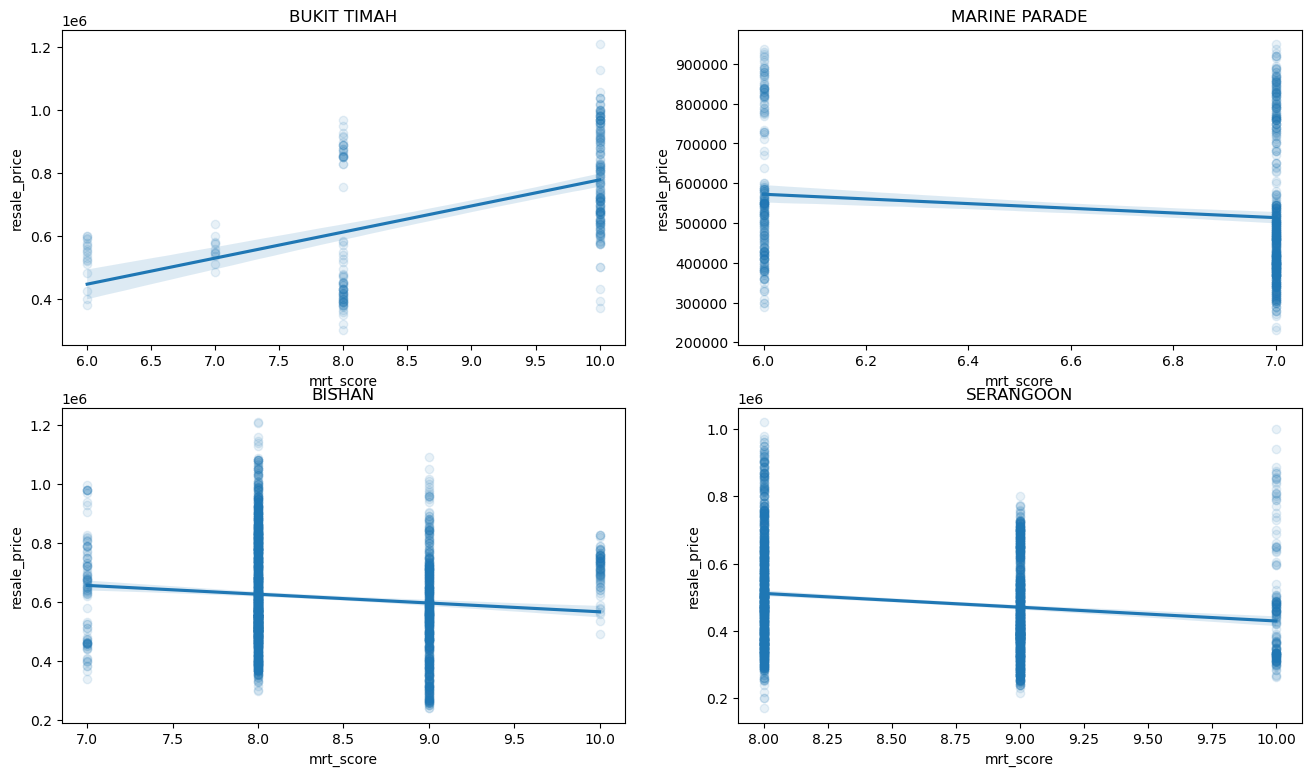

In [ ]:
plotter('mrt_score', ['BUKIT TIMAH', 'MARINE PARADE', 'BISHAN', 'SERANGOON'])

In [ ]:
median_resale_price_by_mrt_score = [X_train[X_train['mrt_score']==score]['resale_price'].median() for score in range(16)]
median_resale_price_by_mrt_score

[602000.0,
 526000.0,
 590000.0,
 625000.0,
 400000.0,
 444488.88,
 460000.0,
 395000.0,
 458000.0,
 400000.0,
 390000.0,
 430000.0,
 418000.0,
 440000.0,
 410500.0,
 380000.0]

In [ ]:
mean_resale_price_by_mrt_score = [X_train[X_train['mrt_score']==score]['resale_price'].mean() for score in range(16)]
mean_resale_price_by_mrt_score

[617143.8254996897,
 538949.4031647746,
 580553.786259542,
 591616.5826018655,
 467027.8611257233,
 505503.269979992,
 490678.9338595042,
 455966.41148246196,
 494349.09571428574,
 438235.44812309684,
 416899.50845039607,
 439798.31518200727,
 428179.38719364826,
 449374.7779081023,
 425835.01655612246,
 388993.16351272963]

Text(0, 0.5, 'Median Resale Price ($)')

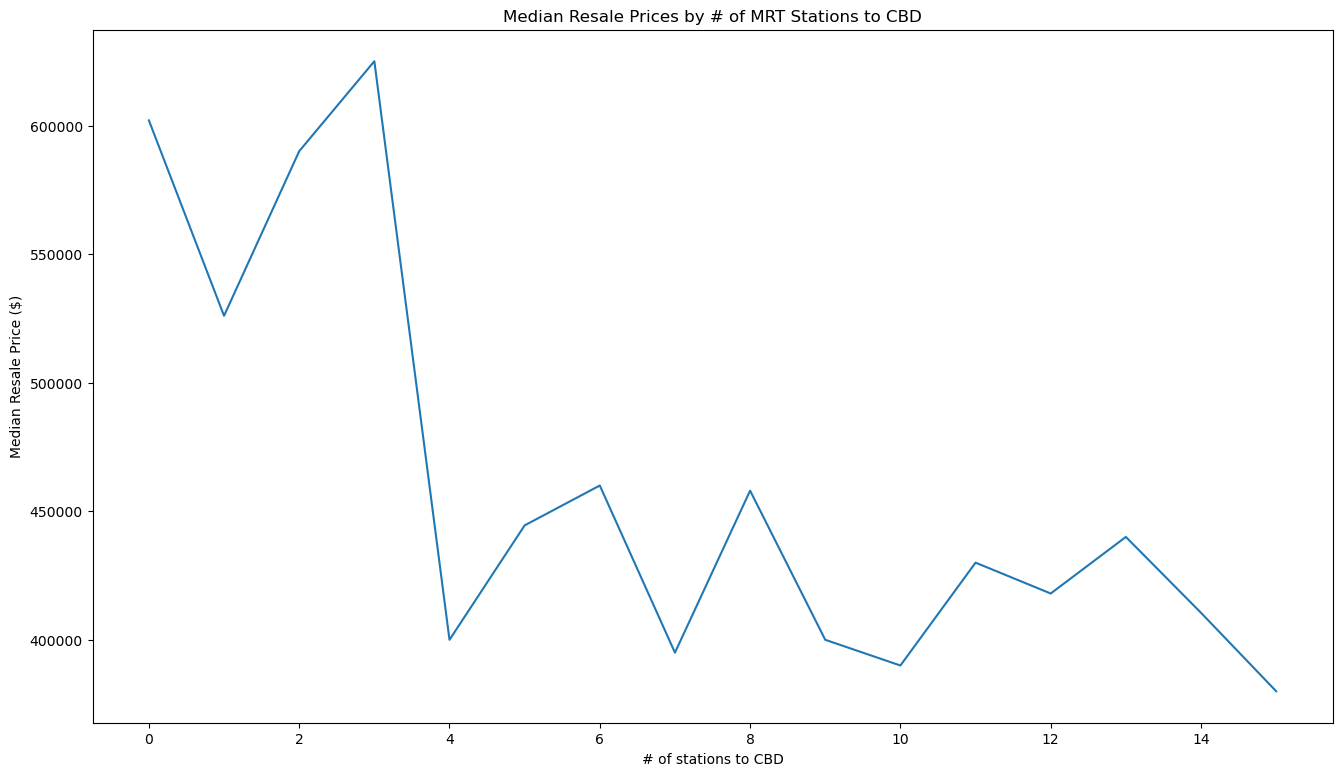

In [ ]:
plt.figure(figsize=(16,9))

plt.plot(range(16),
         median_resale_price_by_mrt_score)

plt.title('Median Resale Prices by # of MRT Stations to CBD')
plt.xlabel('# of stations to CBD')
plt.ylabel('Median Resale Price ($)')

Text(0, 0.5, 'Mean Resale Price ($)')

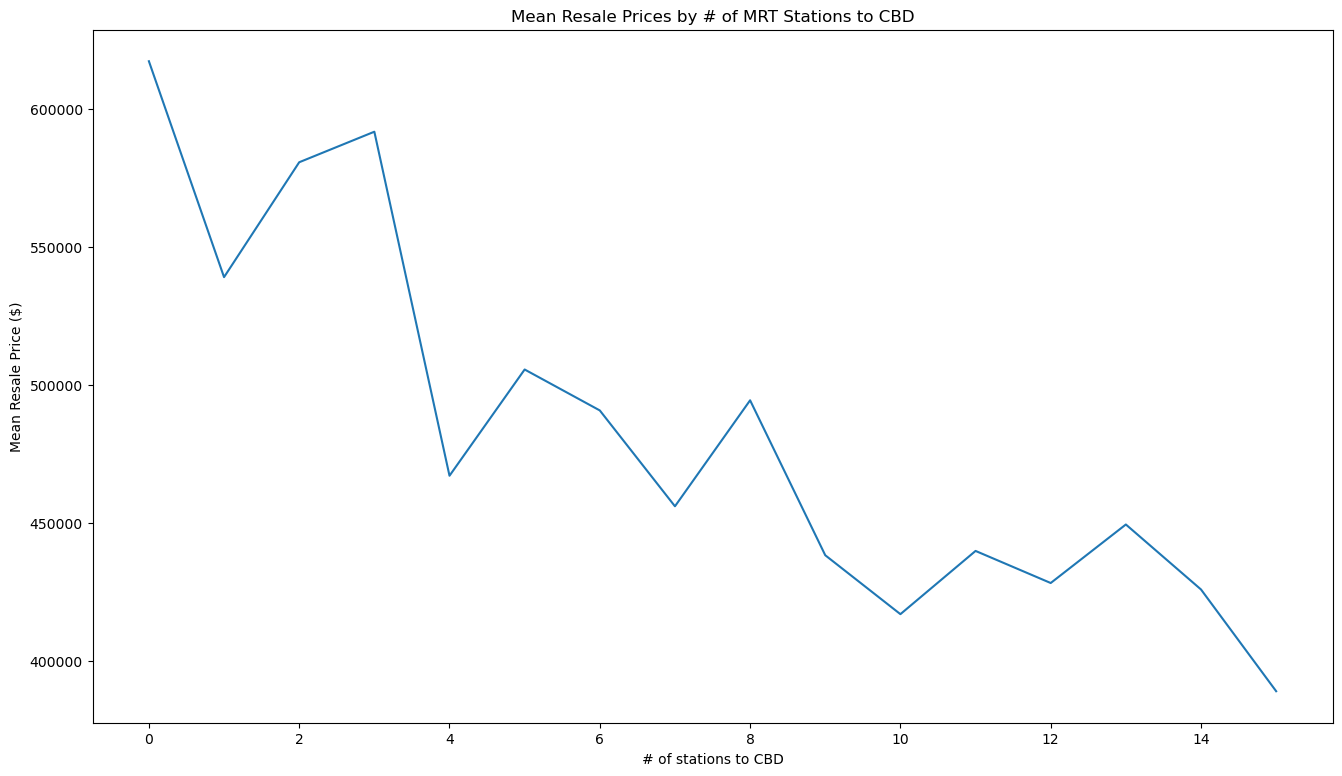

In [ ]:
plt.figure(figsize=(16,9))

plt.plot(range(16),
         mean_resale_price_by_mrt_score)

plt.title('Mean Resale Prices by # of MRT Stations to CBD')
plt.xlabel('# of stations to CBD')
plt.ylabel('Mean Resale Price ($)')

Text(0, 0.5, 'Mean Resale Price ($)')

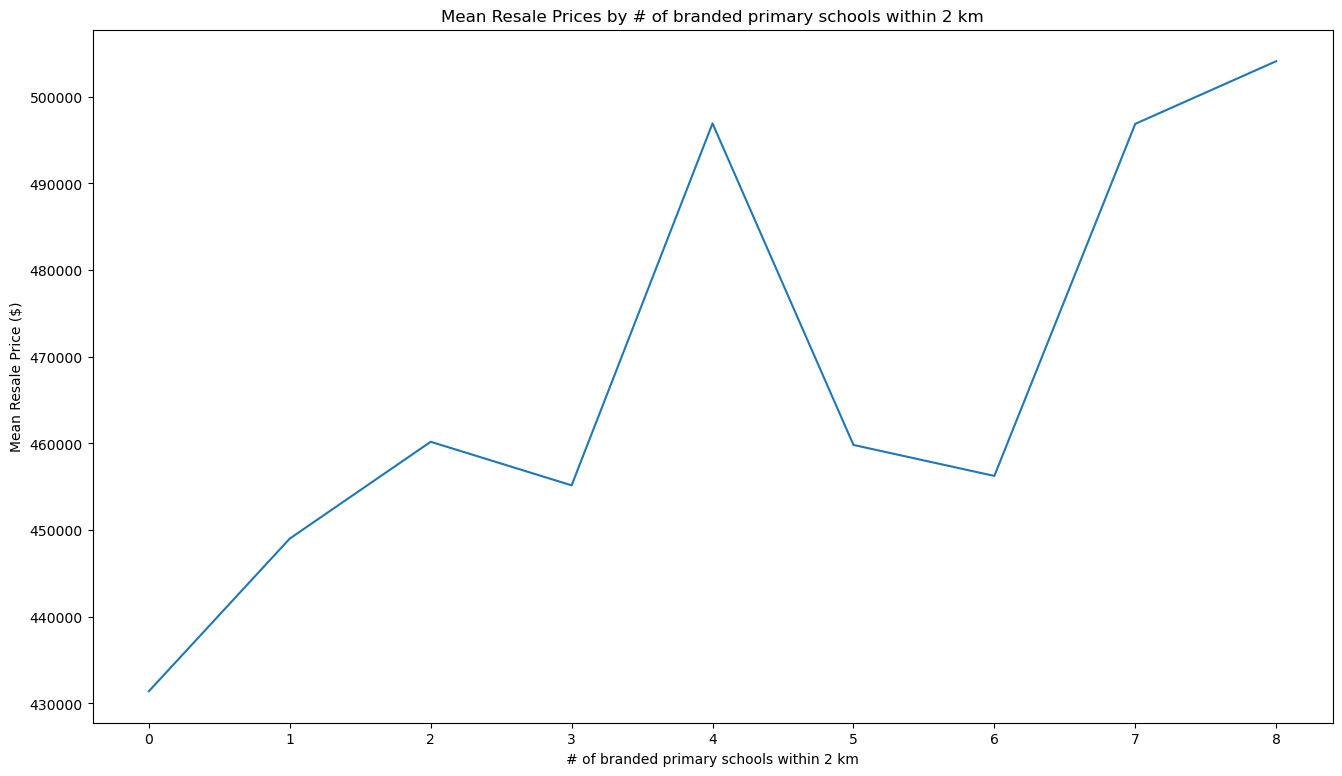

In [ ]:
mean_resale_price_by_branded_pri_2 = [X_train[X_train['brand_pri_sch_within_0-1km']+X_train['brand_pri_sch_within_1-2km']==num]['resale_price'].mean() for num in range(
    X_train['brand_pri_sch_within_0-1km'].max()+X_train['brand_pri_sch_within_1-2km'].max()+1
)]

plt.figure(figsize=(16,9))

plt.plot(range(X_train['brand_pri_sch_within_0-1km'].max()+X_train['brand_pri_sch_within_1-2km'].max()+1),
         mean_resale_price_by_branded_pri_2)

plt.title('Mean Resale Prices by # of branded primary schools within 2 km')
plt.xlabel('# of branded primary schools within 2 km')
plt.ylabel('Mean Resale Price ($)')

Text(0, 0.5, 'Mean Resale Price ($)')

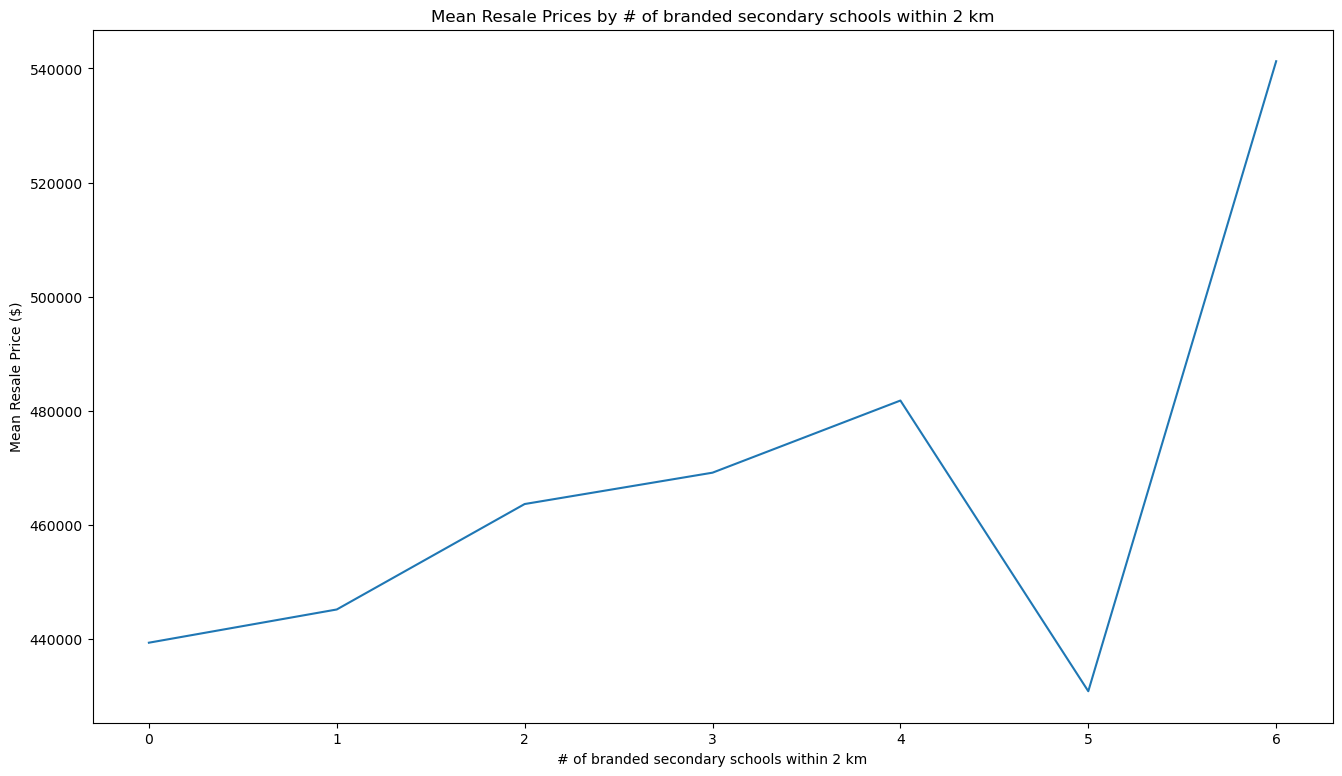

In [ ]:
mean_resale_price_by_branded_sec_2 = [X_train[X_train['brand_sec_sch_within_0-1km']+X_train['brand_sec_sch_within_1-2km']==num]['resale_price'].mean() for num in range(
    X_train['brand_sec_sch_within_0-1km'].max()+X_train['brand_sec_sch_within_1-2km'].max()+1
)]

plt.figure(figsize=(16,9))

plt.plot(range(X_train['brand_sec_sch_within_0-1km'].max()+X_train['brand_sec_sch_within_1-2km'].max()+1),
         mean_resale_price_by_branded_sec_2)

plt.title('Mean Resale Prices by # of branded secondary schools within 2 km')
plt.xlabel('# of branded secondary schools within 2 km')
plt.ylabel('Mean Resale Price ($)')

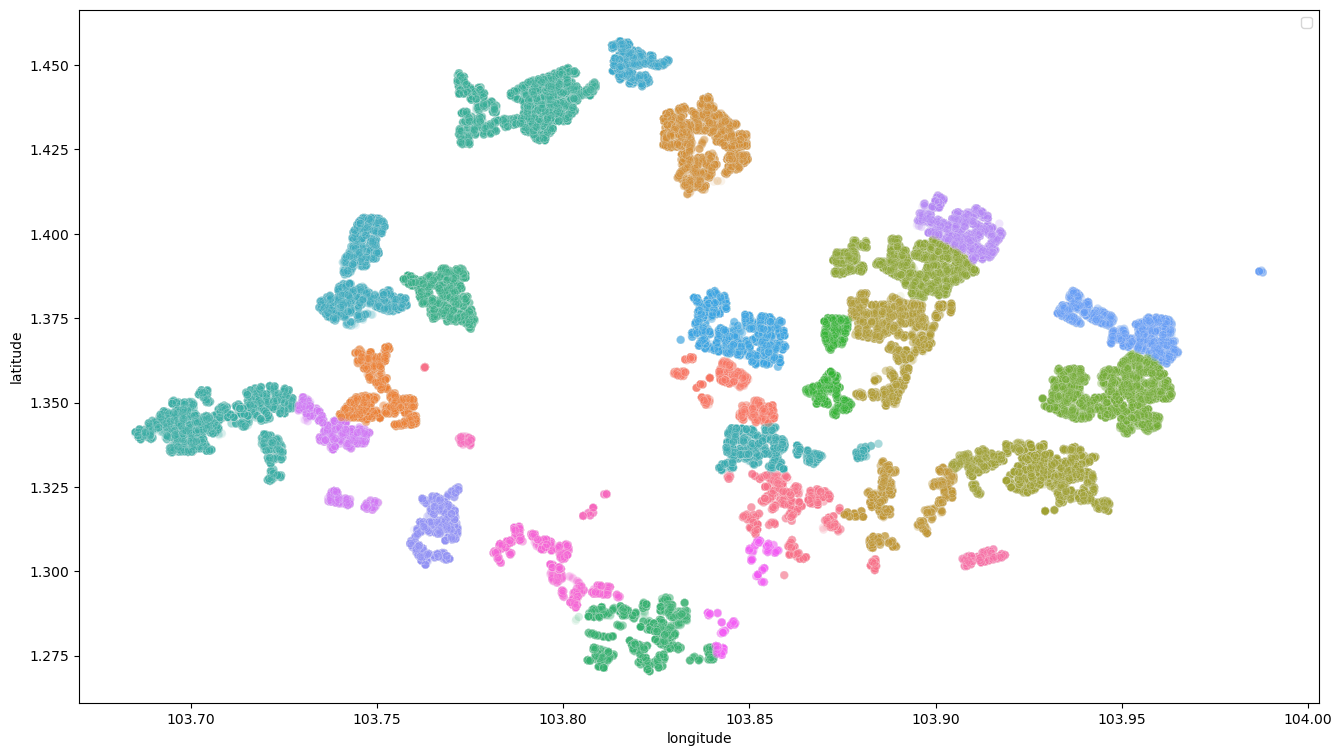

In [ ]:
plt.figure(figsize=(16,9))
sns.scatterplot(init_train_df, x='longitude', y='latitude', hue='town', alpha=0.1)
plt.legend(handles=[])